In [1]:
#!pip install plotly
# ----- importing libraries needed
import numpy as np
import matplotlib
import scipy
import pylab
import netCDF4 as nc4
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import struct
import glob
import pandas as pd
import datetime as dt
import random
import datetime
import plotly.plotly as py  # tools to communicate with Plotly's server
#import xarray as xr
from numpy import convolve
from cloudnetFunctions import CheckIceLiquidCloudnet
from cloudnetFunctions import f_calculateCloudMaskCloudnet

from myFunctions import f_closest
from myFunctions import getNearestIndex
from myFunctions import getIndexList
from myFunctions import getIndexListsuka
from myFunctions import getResampledDataPd
from myFunctions import hourDecimal_to_datetime
from myFunctions import f_calcTheta_MWR
%matplotlib inline  

In [3]:
#------ providing input directories
PathIn = '/Users/cacquist/Lavoro/PBL_hdcp2_s2/PBL_hdcp2_s2_minion/'
#'/Volumes/CLAMINION/PBL_hdcp2_s2/'
#PathIn = '/media/cacquist/CLAMINION/PBL_hdcp2_s2/'

year =2013
month=5
day=2
date='20130502'
Hcut = 3500.
Hsurf=107.
pathFig = PathIn+'figs/'

#------ reading input data from ICON, CLOUDNET, MWR data and PBL classification
#----------------------------------------------------------------------------------
# ----- reading ICON, CLOUDNET and PBL data
ICON_data = Dataset(PathIn+'PBL_properties_DOM03_20130502_JOYCE.nc', mode='r')
OBS_PBL_data = Dataset(PathIn+'20130502_bl_classification_juelich_t_3min.nc', mode='r')
CLOUDNET_data = Dataset(PathIn+'20130502_juelich_categorize.nc', mode='r')
#MWR_data = Dataset(PathIn+'sups_joy_mwr00_l2_clwvi_v01_20130502000018.nc', mode='r')
#PRW_data = Dataset(PathIn+'sups_joy_mwr00_l2_prw_v01_20130502000018.nc', mode='r')
#HUA_data = Dataset(PathIn+'sups_joy_mwr00_l2_hua_v01_20130502000018.nc', mode='r')
#TA_data = Dataset(PathIn+'sups_joy_mwr00_l2_ta_v01_20130502000018.nc', mode='r')
# reading data from SUNHAT zenith pointing during HOPE
MWR_data = Dataset(PathIn+'130502_hps_l2a.nc', mode='r')
PRW_data = Dataset(PathIn+'130502_hps_l2a.nc', mode='r')
HUA_data = Dataset(PathIn+'130502_hph_l2b.nc', mode='r')
TA_data = Dataset(PathIn+'130502_hph_l2b.nc', mode='r')

# ----- reading PBL class data variables
time_PBL_class = OBS_PBL_data.variables['time'][:].copy()
height_PBL_class  = OBS_PBL_data.variables['height'][:].copy()
PBLclass = OBS_PBL_data.variables['bl_classification'][:].copy()
#PBLclass = PBLclass[np.where(time_PBL_class < 2.)[0], :]
datetime_PBL = hourDecimal_to_datetime(year, month, day, time_PBL_class)
beta = OBS_PBL_data.variables['beta'][:].copy()
eps = OBS_PBL_data.variables['eps'][:].copy()
shear = OBS_PBL_data.variables['shear'][:].copy()
skew = OBS_PBL_data.variables['skew'][:].copy()
w = OBS_PBL_data.variables['velo'][:].copy()
Hwind = OBS_PBL_data.variables['speed'][:].copy()

# ----- reading MWR radiometer data variables for la and lb formats
time_MWR = MWR_data.variables['time'][:].copy()
LWP_MWR = MWR_data.variables['atmosphere_liquid_water_content'][:].copy()    # liquid water path [kg m^-2]
# creating time array for LWP in date time format
TA_MWR = TA_data.variables['tprof'][:].copy()         # air temperature [K]
HUA_MWR = HUA_data.variables['qprof'][:].copy()      # absolute humidity [kg m^-3]
IWV_MWR = PRW_data.variables['atmosphere_water_vapor_content'][:].copy()      # integrated water vapor [kg m^-2]
datetime_IWV = nc4.num2date(PRW_data.variables['time'][:],PRW_data.variables['time'].units)
datetime_HUA = nc4.num2date(HUA_data.variables['time'][:],HUA_data.variables['time'].units)
datetime_MWR = nc4.num2date(MWR_data.variables['time'][:],MWR_data.variables['time'].units) 
datetime_TA = nc4.num2date(TA_data.variables['time'][:],TA_data.variables['time'].units) 
height_HUA = HUA_data.variables['z'][:].copy()
height_TA = TA_data.variables['z'][:].copy()


# ----- reading tower measurements
from myFunctions import f_readingTowerData
tower_dict = f_readingTowerData(date, PathIn)
P_surf = tower_dict['P'][:]
T_surf = tower_dict['Tsurf'][:]
RH_surf = tower_dict['RHsurf'][:]
datetime_tower = tower_dict['time'][:]

# ----- reading ICON data variables
time_ICON = ICON_data.groups['Temp_data'].variables['datetime_ICON'][:].copy()

#time_ICON = time_ICON[np.where(time_ICON < 24.)[0]]   # cutting values larger than 24. in time
cloudMask_ICON = ICON_data.groups['Temp_data'].variables['cloudMask'][:]
#cloudMask_ICON2 = cloudMask_ICON[np.where(time_ICON < 24.)[0], :] # resize matrices accordingly
datetime_ICON = nc4.num2date(ICON_data.groups['Temp_data'].variables['datetime_ICON'][:],ICON_data.groups['Temp_data'].variables['datetime_ICON'].units) 
height_ICON = ICON_data.groups['Temp_data'].variables['height'][:].copy()
skewness_ICON = ICON_data.groups['Temp_data'].variables['skewnessW'][:].copy()
theta_ICON = ICON_data.groups['Temp_data'].variables['theta'][:].copy()
thetal_ICON = ICON_data.groups['Temp_data'].variables['theta_liquid'][:].copy()
varw_ICON = ICON_data.groups['Temp_data'].variables['varianceW'][:].copy()
Hwind_ICON = ICON_data.groups['Temp_data'].variables['windSpeed'][:].copy()
shear_ICON = ICON_data.groups['Temp_data'].variables['shearHwind'][:].copy()
alphaq_ICON = ICON_data.groups['Temp_data'].variables['alpha_q'][:].copy()
alphatheta_ICON = ICON_data.groups['Temp_data'].variables['alpha_q'][:].copy()
cloudBase_ICON = ICON_data.groups['Temp_data'].variables['cloudBaseHeightArr'][:].copy()
LTS_ICON = ICON_data.groups['Temp_data'].variables['LTS'][:].copy()
LCL_ICON = ICON_data.groups['Temp_data'].variables['LCLarray'][:].copy()
w_ICON = ICON_data.groups['Temp_data'].variables['vertWind'][:].copy()
RH_ICON = ICON_data.groups['Temp_data'].variables['RH'][:].copy()
mixingRatio_ICON = ICON_data.groups['Temp_data'].variables['r'][:].copy()
specHum_ICON = ICON_data.groups['Temp_data'].variables['q'][:].copy()
Hsurf = ICON_data.groups['Temp_data'].variables['Height_surface'][:].copy()
IWV_ICON = ICON_data.groups['Temp_data'].variables['IWV'][:].copy()
LWP_ICON = ICON_data.groups['Temp_data'].variables['LWP'][:].copy()
P_ICON = ICON_data.groups['Temp_data'].variables['P'][:].copy()
PBL_class_ICON = ICON_data.groups['Temp_data'].variables['PBLclass'][:].copy()
PBL_height_ICON = ICON_data.groups['Temp_data'].variables['PBLHeightArr'][:].copy()
T_ICON = ICON_data.groups['Temp_data'].variables['T'][:].copy()

# ----- reading CLOUDNET data variables
time_CLOUDNET = CLOUDNET_data.variables['time'][:].copy()
height_CLOUDNET = CLOUDNET_data.variables['height'][:].copy()
datetime_CLOUDNET = hourDecimal_to_datetime(year, month, day, time_CLOUDNET)
cloudnet = CLOUDNET_data.variables['category_bits'][:].copy()
Ze_CLOUDNET = CLOUDNET_data.variables['Z'][:].copy()
Vd_CLOUDNET = CLOUDNET_data.variables['v'][:].copy()
Sw_CLOUDNET = CLOUDNET_data.variables['width'][:].copy()


# ---- reading data from radiosondes
z_ccl_radiosondes = [948.1, 938.1, 968.4, 1400.8, 1455.7, 1406.9, 1464.3]
T_ccl_radiosondes = [289.47138, 289.23338, 289.8803, 291.78784, 292.29586, 292.47762, 292.15014]
Td_surf_radiosondes = [ 282.15,  281.75,  281.45,  281.95,  281.85,  280.45,  279.45]
time_ccl_radiosondes = ['2013-05-02 07:00:00', '2013-05-02 09:00:00', '2013-05-02 11:00:00',\
                        '2013-05-02 13:00:00', '2013-05-02 15:00:00', '2013-05-02 17:00:00', '2013-05-02 23:00:00']
a=pd.to_datetime(time_ccl_radiosondes)
time_ccl_rs = np.array(a,dtype=np.datetime64)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/i

In [4]:
#------ regridding variables on ICON time grid
#---------------------------------------------------------------------------------
# ---- defining ICON data as dataframe reference
ICON_DF= pd.DataFrame(cloudMask_ICON, index=datetime_ICON, columns=height_ICON)

# ---- resampling PBL classification on ICON resolution
print('resampling PBL observations on ICON time resolution')
PBL_DF = pd.DataFrame(PBLclass, index=datetime_PBL, columns=height_PBL_class)
SelectedIndex = getIndexList(PBL_DF, ICON_DF.index)
values = np.zeros((len(datetime_ICON),len(height_PBL_class)))
PBL_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
PBL_resampled = getResampledDataPd(PBL_resampled, PBL_DF, SelectedIndex)

# ---- resampling backscatter coefficient on ICON resolution
beta_DF = pd.DataFrame(beta, index=datetime_PBL, columns=height_PBL_class)
beta_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
beta_resampled = getResampledDataPd(beta_resampled, beta_DF, SelectedIndex)

# ---- resampling eddy dissipation rate on ICON resolution
eps_DF = pd.DataFrame(eps, index=datetime_PBL, columns=height_PBL_class)
eps_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
eps_resampled = getResampledDataPd(eps_resampled, eps_DF, SelectedIndex)

# ---- resampling wind shear on ICON resolution
shear_DF = pd.DataFrame(shear, index=datetime_PBL, columns=height_PBL_class)
shear_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
shear_resampled = getResampledDataPd(shear_resampled, shear_DF, SelectedIndex)

# ---- resampling skewness of vertical velocity on ICON resolution
skew_DF = pd.DataFrame(skew, index=datetime_PBL, columns=height_PBL_class)
skew_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
skew_resampled = getResampledDataPd(skew_resampled, skew_DF, SelectedIndex)

# ---- resampling vertical velocity on ICON resolution
w_DF = pd.DataFrame(w, index=datetime_PBL, columns=height_PBL_class)
w_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
w_resampled = getResampledDataPd(w_resampled, w_DF, SelectedIndex)

# ---- resampling horizontal wind on ICON resolution
Hwind_DF = pd.DataFrame(Hwind, index=datetime_PBL, columns=height_PBL_class)
Hwind_resampled = pd.DataFrame(values, index=datetime_ICON, columns=height_PBL_class)
Hwind_resampled = getResampledDataPd(Hwind_resampled, Hwind_DF, SelectedIndex)
print('PBL variables resampled: PBL, beta, eps, shear, skewness, w, Hwind')


# ---- resampling cloudnet classification on ICON resolution
print('resampling CLOUDNET observations on ICON time resolution')
CLOUDNET_DF = pd.DataFrame(cloudnet, index=datetime_CLOUDNET, columns=height_CLOUDNET)
SelectedIndex_CN = getIndexList(CLOUDNET_DF, ICON_DF.index)
values_CN = np.zeros((len(datetime_ICON),len(height_CLOUDNET)))
CLOUDNET_resampled = pd.DataFrame(values_CN, index=datetime_ICON, columns=height_CLOUDNET)
cat_resampled = getResampledDataPd(CLOUDNET_resampled, CLOUDNET_DF, SelectedIndex_CN)

#Ze_DF = pd.DataFrame(Ze_CLOUDNET, index=datetime_CLOUDNET, columns=height_CLOUDNET)
#Ze_resampled = pd.DataFrame(values_CN, index=datetime_ICON, columns=height_CLOUDNET)
#Ze_resampled = getResampledDataPd(Ze_resampled, Ze_DF, SelectedIndex_CN)

#Vd_DF = pd.DataFrame(Vd_CLOUDNET, index=datetime_CLOUDNET, columns=height_CLOUDNET)
#Vd_resampled = getResampledDataPd(CLOUDNET_resampled, Vd_DF, SelectedIndex_CN)
#Sw_DF = pd.DataFrame(Sw_CLOUDNET, index=datetime_CLOUDNET, columns=height_CLOUDNET)
#Sw_resampled = getResampledDataPd(CLOUDNET_resampled, Sw_DF, SelectedIndex_CN)
print('CLOUDNET variables resampled: categorization, Ze, Vd, Sw')

# ---- resamplig tower observations
print('resampling tower observations on ICON time resolution')
Psurf_DF = pd.DataFrame(P_surf, index=datetime_tower)
SelectedIndex_tower = getIndexList(Psurf_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
Psurf_resampled = pd.DataFrame(values, index=datetime_ICON)
Psurf_resampled = getResampledDataPd(Psurf_resampled, Psurf_DF, SelectedIndex_tower)

Tsurf_DF = pd.DataFrame(T_surf, index=datetime_tower)
SelectedIndex_tower_T = getIndexList(Tsurf_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
Tsurf_resampled = pd.DataFrame(values, index=datetime_ICON)
Tsurf_resampled = getResampledDataPd(Tsurf_resampled, Tsurf_DF, SelectedIndex_tower_T)



RHsurf_DF = pd.DataFrame(RH_surf, index=datetime_tower)
SelectedIndex_tower_RH = getIndexList(RHsurf_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
RHsurf_resampled = pd.DataFrame(values, index=datetime_ICON)
RHsurf_resampled = getResampledDataPd(RHsurf_resampled, RHsurf_DF, SelectedIndex_tower_RH)
print('resampled tower observations: Psurf, Tsurf, RHsurf')

# ---- resampling MWR LWP observations on ICON resolution
print('resampling MWR observations on ICON time resolution')

# ---- resampling LWP
LWP_DF = pd.DataFrame(LWP_MWR, index=datetime_MWR)
# ---- removing double values
LWP_DF = LWP_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
SelectedIndex_MWR = getIndexList(LWP_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
MWR_resampled = pd.DataFrame(values, index=datetime_ICON)
MWR_resampled = getResampledDataPd(MWR_resampled, LWP_DF, SelectedIndex_MWR)



# ---- resampling IWV
IWV_DF = pd.DataFrame(IWV_MWR, index=datetime_IWV)
# ---- removing double values
IWV_DF = IWV_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
SelectedIndex_IWV = getIndexList(IWV_DF, ICON_DF.index)
IWV_resampled = pd.DataFrame(values, index=datetime_ICON)
IWV_resampled = getResampledDataPd(IWV_resampled, IWV_DF, SelectedIndex_IWV)


# ---- resampling T
TA_DF = pd.DataFrame(TA_MWR, index=datetime_TA)
# ---- removing double values
TA_DF = TA_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
values_TA = np.zeros((len(datetime_ICON),len(height_TA)))
SelectedIndex_TA = getIndexList(TA_DF, ICON_DF.index)
TA_resampled = pd.DataFrame(values_TA, index=datetime_ICON)
TA_resampled = getResampledDataPd(TA_resampled, TA_DF, SelectedIndex_TA)


# ---- resampling absolute humidity
QA_DF = pd.DataFrame(HUA_MWR, index=datetime_HUA)
# ---- removing double values
QA_DF = QA_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
values_HUA = np.zeros((len(datetime_ICON),len(height_HUA)))
SelectedIndex_QA = getIndexList(QA_DF, ICON_DF.index)
QA_resampled = pd.DataFrame(values_HUA, index=datetime_ICON)
QA_resampled = getResampledDataPd(QA_resampled, QA_DF, SelectedIndex_QA)


print('MWR radiometer variables resampled: LWP, IWV, T, Q')

resampling PBL observations on ICON time resolution
PBL variables resampled: PBL, beta, eps, shear, skewness, w, Hwind
resampling CLOUDNET observations on ICON time resolution
CLOUDNET variables resampled: categorization, Ze, Vd, Sw
resampling tower observations on ICON time resolution
resampled tower observations: Psurf, Tsurf, RHsurf
resampling MWR observations on ICON time resolution
MWR radiometer variables resampled: LWP, IWV, T, Q


In [7]:
# ---- derive physical quantities needed for the analysis from the observations ( LTS, theta, LCL - cloud base, cloud mask
# cloud thickness, P, T, theta, CCL, z_ccl, T_ccl, Td)
# ----- calculating theta and theta_eq from MWR observations 
#output: a dictionary containing:
    #         'height':height_TA,
    #         "P_baro":P_baro,
    #         'theta': theta,
    #         'theta_e':theta_e,
    #         'mixingRatio':mr
    #         'Td':Td,
    #         'z_ccl':z_ccl,
    #         'T_ccl':T_ground_CCL
    
from myFunctions import f_calcTheta_MWR
PbaroSurf = np.array(Psurf_resampled.values)
MWR_dict = f_calcTheta_MWR(QA_resampled, TA_resampled, PbaroSurf, datetime_ICON, height_TA)
theta = MWR_dict['theta'][:]
P = MWR_dict['Pbaro'][:]
height = MWR_dict['height'][:]
T = TA_resampled.values
z_ccl_MWR = MWR_dict['z_ccl'][:]
T_ccl_MWR = MWR_dict['T_ccl'][:]
Td_MWR = MWR_dict['Td'][:]
Td_surf_MWR = Td_MWR[:,0]

151
()


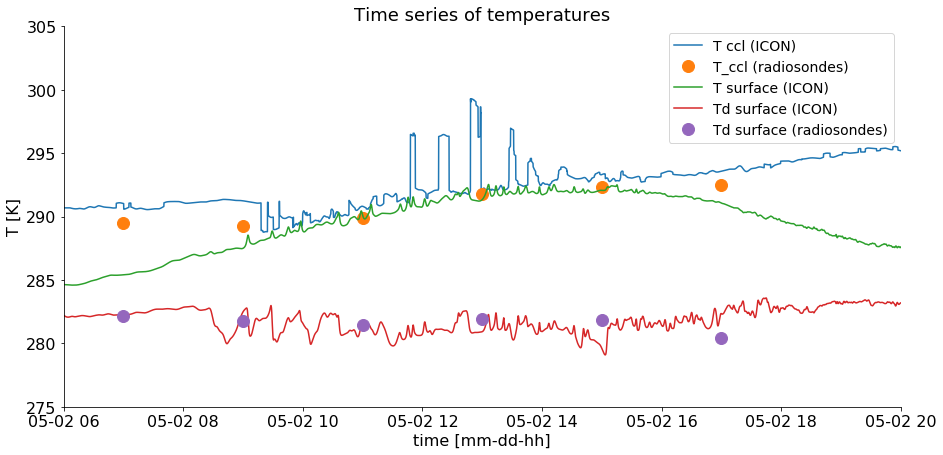

In [6]:
from myFunctions import f_CCL
result = f_CCL(T_ICON, P_ICON, RH_ICON, height_ICON, datetime_ICON, Hsurf)
print(np.shape(result))

import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

Td_ICON = result['Td'][:]
T_ccl = result['T_ccl'][:]
z_ccl = result['z_ccl'][:]
fig, ax = plt.subplots(figsize=(15,7))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(datetime_ICON, T_ccl, label='T ccl (ICON)')
plt.plot(time_ccl_rs, T_ccl_radiosondes, 'o', markersize=12, label='T_ccl (radiosondes)')
#plt.plot(datetime_ICON, T_ccl_MWR, label='T ccl (MWR)')

plt.plot(datetime_ICON, T_ICON[:,149], label='T surface (ICON)')
plt.plot(datetime_ICON, Td_ICON[:,149], label='Td surface (ICON)')
#plt.plot(datetime_ICON, Td_surf_MWR[:], label='Td surface (MWR)')

plt.plot(time_ccl_rs, Td_surf_radiosondes, 'o', markersize=12, label='Td surface (radiosondes)')

plt.legend(loc='upper right', fontsize=14)
plt.title('Time series of temperatures', fontsize=18)
plt.ylabel('T [K]', fontsize=16)
plt.ylim(275., 305.)
plt.xlabel('time [mm-dd-hh]', fontsize=16)
plt.xlim(datetime.datetime(2013,5,2,6,0,0),datetime.datetime(2013,5,2,20,0,0))
plt.savefig(pathFig+'T_timeseries.png')

In [10]:
# ---- calculate variance of vertical velocity for observations using a running mean over 30 min
timewindow = 10 # time window corresponding to 30 min considering that PBL data have time resolution of 3 minutes
from myFunctions import f_calcWvariance
varianceW_obs = f_calcWvariance(w_resampled.values,datetime_ICON,height_PBL_class,timewindow)

/Users/cacquist/Lavoro/PBL_hdcp2_s2/PBL_hdcp2_s2_minion/myFunctions.py:484: FutureWarning:

pd.rolling_std is deprecated for ndarrays and will be removed in a future version



LTS calculated
151
()


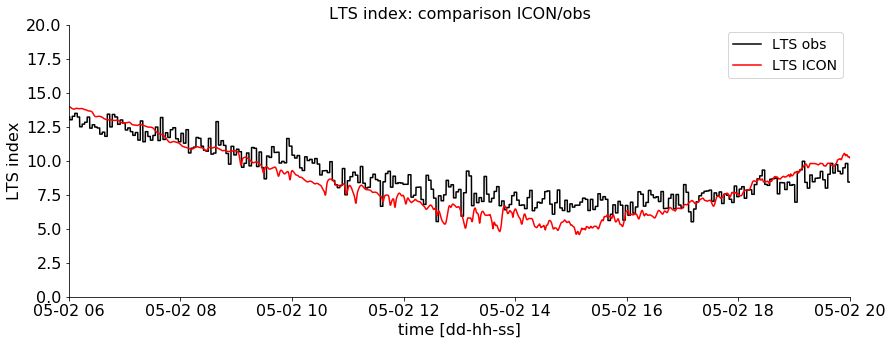

In [8]:
# ------------------------------------------------------------------
# calculate LTS index for lower tropospheric stability (Wood and Bretherton, 2006) and skewness of vertical velocity below cloud base
# ------------------------------------------------------------------
dimTime = len(datetime_ICON)
LTS = np.zeros(dimTime)
H700 = np.zeros(dimTime)
Pthr = 700 * 100. # Pressure level of 700 Hpa used as a reference
# calculating height of the surface
indSurf = f_closest(height_ICON,Hsurf)
for iTime in range(dimTime):
    indP700 = f_closest(P[iTime,:],Pthr)
    LTS[iTime] = theta[iTime, indP700] - theta[iTime, indSurf]
    H700[iTime] = height[indP700]
print('LTS calculated')

# ------------------------------------------------------------------
# calculate CCL height and temperature 
# ------------------------------------------------------------------
from myFunctions import f_CCL
result = f_CCL(T_ICON, P_ICON, RH_ICON, height_ICON, datetime_ICON, Hsurf)
print(np.shape(result))

#plt.plot(datetime_ICON[0:len(datetime_ICON)-1],PbaroSurf[0:len(datetime_ICON)-1])
fig, ax = plt.subplots(figsize=(14,5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(datetime_ICON, LTS, color='black', label='LTS obs')
plt.plot(datetime_ICON, LTS_ICON, color='red', label='LTS ICON')
plt.title('LTS index: comparison ICON/obs', fontsize=16)
plt.ylabel('LTS index', fontsize=16)
plt.xlabel('time [dd-hh-ss]', fontsize=16)
plt.ylim(0,20)
plt.legend(loc='upper right', fontsize=14)
plt.xlim(datetime.datetime(2013,5,2,6,0,0),datetime.datetime(2013,5,2,20,0,0))

plt.savefig(pathFig+'LTS_timeserie_obs_ICON.png')

(9601,)
(9601, 1)
LCL calculated


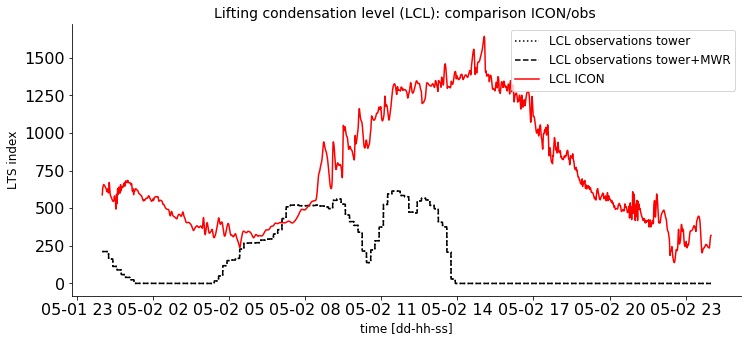

In [9]:
#------ calculating LCL heights from tower measurements resampled
#---------------------------------------------------------------------------------
LCLarray = []
LCLarray2 = []
from myFunctions import lcl
P_lcl = Psurf_resampled.values
T_lcl = Tsurf_resampled.values
RH_lcl = RHsurf_resampled.values
T_lcl2 = TA_resampled.values[:,0]
print(np.shape(T_lcl2))
print(np.shape(P_lcl))

for iTime in range(len(datetime_ICON)):
    LCLarray.append(lcl(P_lcl[iTime],T_lcl[iTime],RH_lcl[iTime]/100.))
    LCLarray2.append(lcl(P_lcl[iTime],T_lcl2[iTime],RH_lcl[iTime]/100.))
    

    
print('LCL calculated')
fig, ax = plt.subplots(figsize=(12,5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(datetime_ICON, LCLarray, color='black', linestyle=':', label='LCL observations tower')
plt.plot(datetime_ICON, LCLarray, color='black', linestyle='--',label='LCL observations tower+MWR')
plt.plot(datetime_ICON, LCL_ICON, color='red', label='LCL ICON')
plt.ylabel('LTS index', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.title('Lifting condensation level (LCL): comparison ICON/obs ', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig(pathFig+'LCL_timeserie_obs_ICON.png')


In [10]:
#------ calculating cloud mask for cloudnet target classification
#---------------------------------------------------------------------------------
from cloudnetFunctions import f_calculateCloudMaskCloudnet
matrix = cat_resampled.values
cloudMask_CLOUDNET = f_calculateCloudMaskCloudnet(cat_resampled.index, cat_resampled.columns, matrix.astype(int))


In [11]:
# ----- filtering cloud masks above 3000 mt to focus only on PBL clouds.
Hcut = 3500.
cloudMaskICON_DF = pd.DataFrame(cloudMask_ICON, index=datetime_ICON, columns=height_ICON)
cloudMask_ICON_PBL = cloudMaskICON_DF.iloc[:, (cloudMaskICON_DF.columns < Hcut)]
height_ICON_PBL = cloudMaskICON_DF.columns[cloudMaskICON_DF.columns < Hcut]

cloudMask_CLOUDNET_DF = pd.DataFrame(cloudMask_CLOUDNET, index=datetime_ICON, columns=height_CLOUDNET)
cloudMask_CLOUDNET_PBL = cloudMask_CLOUDNET_DF.loc[:, (cloudMask_CLOUDNET_DF.columns < Hcut)]
height_CLOUDNET_PBL = cloudMask_CLOUDNET_DF.columns[cloudMask_CLOUDNET_DF.columns < Hcut]


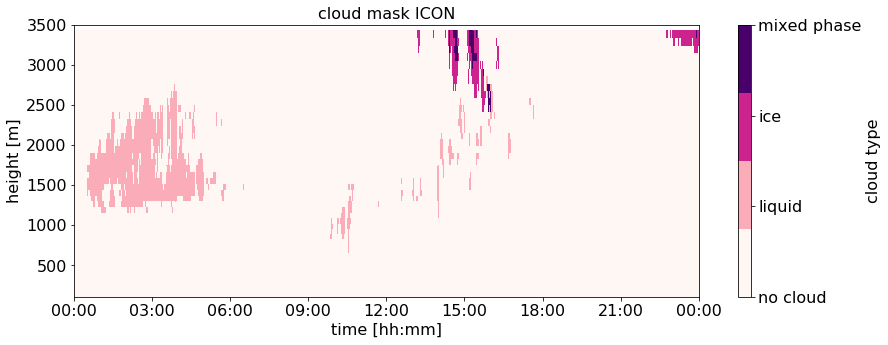

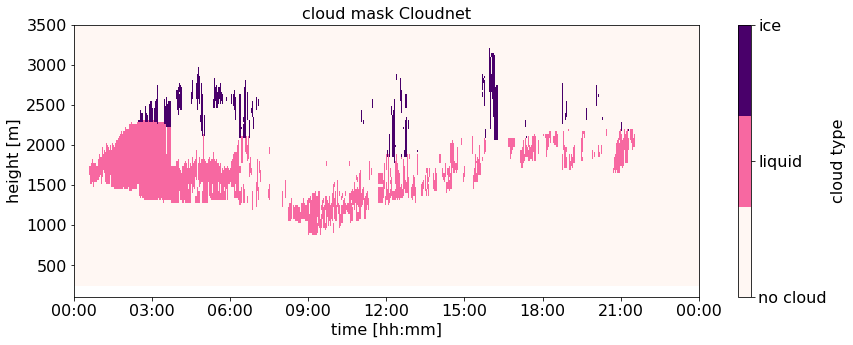

In [12]:
# ----- plotting cloud mask from ICON and cloud mask from observations resampled to ICON resolution
#---------------------------------------------------------------------------------
# ---- plot of cloud mask for ICON 
Hsurf=107.
size = len(datetime_ICON)

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
cax = ax.pcolormesh(datetime_ICON, height_ICON_PBL, cloudMask_ICON_PBL.values.transpose(), vmin=0, vmax=3, cmap=plt.cm.get_cmap("RdPu", 4))
#plt.plot(datetime_ICON, z_ccl, color='red', label='z_ccl (ICON)')
#plt.plot(time_ccl_rs, z_ccl_radiosondes, 'o', color='black', markersize=12,  label='z_ccl (radiosondes)')
ax.set_ylim(Hsurf,Hcut)                         # limits of the y-axes
#ax.set_xlim(0,24)                                 # limits of the x-axes
ax.set_title("cloud mask ICON", fontsize=16)
ax.set_xlabel("time [hh:mm]", fontsize=16)
ax.set_ylabel("height [m]", fontsize=16)
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3], orientation='vertical')
cbar.ticks=([0,1,2,3])
cbar.ax.set_yticklabels(['no cloud','liquid','ice','mixed phase'])
cbar.set_label(label="cloud type",size=16)
cbar.ax.tick_params(labelsize=16)
cbar.aspect=80
plt.savefig(pathFig+'cloudMask_ICON.png')


fig, ax = plt.subplots(figsize=(14,5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
cax = ax.pcolormesh(datetime_ICON, height_CLOUDNET_PBL, cloudMask_CLOUDNET_PBL.values.transpose(), vmin=0, vmax=2, cmap=plt.cm.get_cmap("RdPu", 3))
ax.set_ylim(Hsurf,Hcut)                         # limits of the y-axes
#ax.set_xlim(0,24)                                 # limits of the x-axes
#plt.plot(datetime_ICON, z_ccl, color='red', label='z_ccl (ICON)')
#plt.plot(time_ccl_rs, z_ccl_radiosondes, 'o', color='black', markersize=12,  label='z_ccl (radiosondes)')
ax.set_title("cloud mask Cloudnet", fontsize=16)
ax.set_xlabel("time [hh:mm]", fontsize=16)
ax.set_ylabel("height [m]", fontsize=16)
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3], orientation='vertical')
cbar.ticks=([0,1,2,3])
cbar.ax.set_yticklabels(['no cloud','liquid','ice'])
cbar.set_label(label="cloud type",size=16)
cbar.ax.tick_params(labelsize=16)
cbar.aspect=80
plt.savefig(pathFig+'cloudMask_CLOUDNET.png')


In [13]:
# ----- calculating cloud base height array and cloud top height array for observations and for model output
from myFunctions import f_calcCloudBaseTop
cloudEdges_obs = f_calcCloudBaseTop(cloudMask_CLOUDNET_PBL.values, len(datetime_ICON), len(height_CLOUDNET_PBL), height_CLOUDNET_PBL)
CTarray_obs = cloudEdges_obs[0]
CBarray_obs = cloudEdges_obs[1]
cloudThickness_obs = CTarray_obs-CBarray_obs

cloudEdges_mod = f_calcCloudBaseTop(cloudMask_ICON_PBL.values, len(datetime_ICON), len(height_ICON_PBL), height_ICON_PBL)
CBarray_mod = cloudEdges_mod[0]
CTarray_mod = cloudEdges_mod[1]
cloudThickness_mod = CTarray_mod-CBarray_mod
cloudThickness_mod[np.where(cloudThickness_mod < 0)[0]] = 0.



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in less



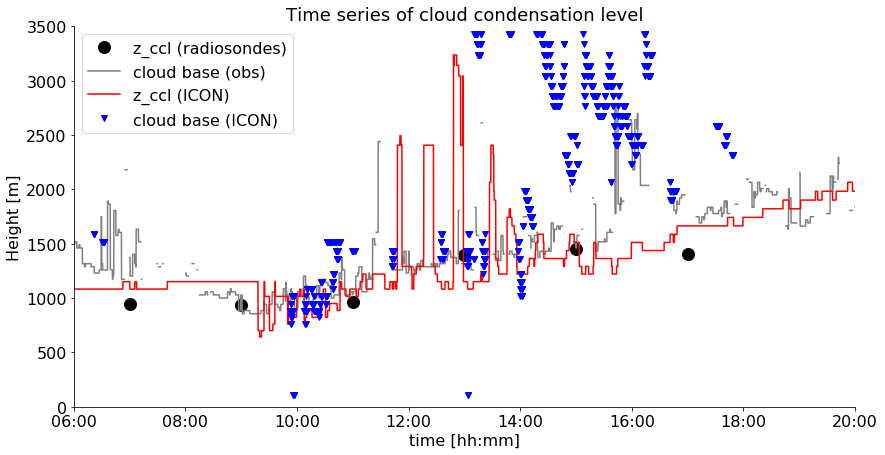

In [14]:
#### --- comparison of cloud base height, Z_ccl from ICON and obs
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,7))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

plt.plot(time_ccl_rs, z_ccl_radiosondes, 'o', color='black', markersize=12,  label='z_ccl (radiosondes)')
plt.plot(datetime_ICON, CBarray_obs[:,0], color='grey', label='cloud base (obs)')
plt.plot(datetime_ICON, z_ccl, color='red', label='z_ccl (ICON)')
plt.plot(datetime_ICON, CBarray_mod[:,0], 'v', color='blue', label='cloud base (ICON)')

#plt.plot(datetime_ICON, z_ccl_MWR, color='blue', label='z_ccl (MWR)')
plt.ylim(0,3500.)
plt.legend(loc='upper left', fontsize=16)
plt.title('Time series of cloud condensation level', fontsize=18)
plt.ylabel('Height [m]', fontsize=16)
plt.xlabel('time [hh:mm]', fontsize=16)
plt.xlim(datetime.datetime(2013,5,2,6,0,0),datetime.datetime(2013,5,2,20,0,0))
plt.savefig(pathFig+'thermodyn_ev_5.png')

In [15]:
np.shape(CBarray_obs)
# ----- finding indeces of cloud base for model and obs
ind_CB_obs = []
ind_CB_mod = []
for indT in range(len(datetime_ICON)):
    ind_CB_obs.append(f_closest(height_CLOUDNET_PBL, CBarray_obs[indT,0]))
    ind_CB_mod.append(f_closest(height_ICON_PBL, CBarray_mod[indT,0]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



(50,)


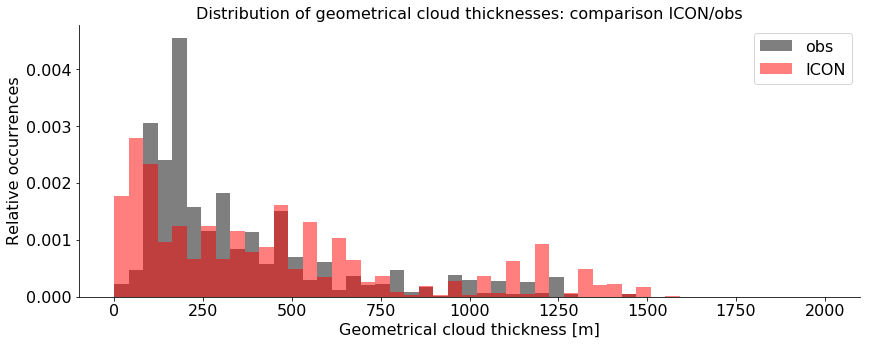

In [16]:
# comparing cloud thicknesses without distinction (PDFs)
from matplotlib import pyplot
xmin =0.
xmax=2000.
nbins=50.
bins = np.linspace(xmin, xmax, nbins)
print(np.shape(bins))
fig, ax = plt.subplots(figsize=(14,5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.hist(cloudThickness_obs[:,0], bins, normed=1, alpha=0.5, label='obs', color='black', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.hist(cloudThickness_mod[:,0], bins, normed=1, alpha=0.5, label='ICON', color='red', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('Relative occurrences', fontsize=16)
plt.xlabel('Geometrical cloud thickness [m]', fontsize=16)
plt.title('Distribution of geometrical cloud thicknesses: comparison ICON/obs', fontsize=16)
plt.savefig(pathFig+'PDF_geoThickness_obs_ICON.png')

In [17]:
# ----- calculating flag for cloud presence for ICON cloud mask and CLOUDNET cloud mask resampled on the ICON grid.
#----------------------------------------------------------------------------------------------------------------
flagCloud_ICON = []
flagCloud_CLOUDNET = []


for ind in range(len(time_ICON)):
    cloudCol_ICON = cloudMask_ICON_PBL.values[ind,:]
    cloudCol_CLOUDNET = cloudMask_CLOUDNET_PBL.values[ind,:]
    indCloudICON = np.where(cloudCol_ICON > 0)[0]
    indCloudCLOUDNET = np.where(cloudCol_CLOUDNET > 0)[0]
    if len(indCloudICON) > 0:
        flagCloud_ICON.append(1)
    else:
        flagCloud_ICON.append(0)
        
    if len(indCloudCLOUDNET) > 0:
        flagCloud_CLOUDNET.append(1)
    else:
        flagCloud_CLOUDNET.append(0)  
        


1337.0
3085.0
4000
386
2675
Percentage of PBL clouds induced by convection in observations
86.709886547812
Percentage of PBL clouds induced by convection in model
28.87060583395662


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning:

invalid value encountered in less

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in less

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning:

invalid value encountered in less

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning:

invalid value encountered in less



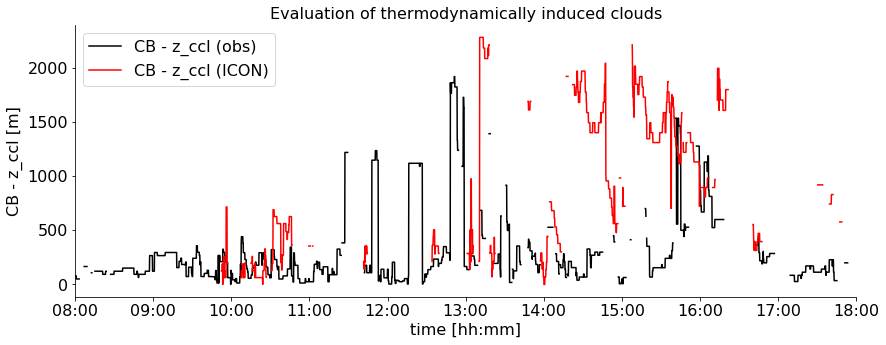

In [18]:
# ---- calculate the amount of clouds created by thermodynamics in the PBL 
# we calculate CB -Z_ccl for the model and check when this parameter is smaller than 350m. 
# We count how many clouds in percentage are formed in the time interval between six and 18 fullfilling this condition over the total number of  time steps
# we compare to the total number of clouds observed in this time interval over the total number of time steps.
par_TRD_mod = []
par_TRD_obs = []
timeSel = []
CB_mod_PBL = []
CB_obs_PBL = []
N_CB_mod = 0.
N_CB_obs = 0.
for indTime in range(len(datetime_ICON)):
    #print(indTime)
    if ((datetime_ICON[indTime] > datetime.datetime(2013,5,2,8,0,0)) and (datetime_ICON[indTime] < datetime.datetime(2013,5,2,18,0,0))):
        par_TRD_mod.append(np.absolute(CBarray_mod[indTime,0] - z_ccl[indTime]))
        par_TRD_obs.append(np.absolute(CBarray_obs[indTime,0] - z_ccl[indTime]))
        timeSel.append(datetime_ICON[indTime])
        CB_mod_PBL.append(CBarray_mod[indTime,0])
        CB_obs_PBL.append(CBarray_obs[indTime,0])
        if np.isnan(CBarray_mod[indTime,0]) == False:
            N_CB_mod = N_CB_mod+1
        if np.isnan(CBarray_obs[indTime,0]) == False:
            N_CB_obs = N_CB_obs+1    

print(N_CB_mod)
print(N_CB_obs)
#print(len(np.where(np.isnan(CBarray_mod[:,0]))))
#print(len(CB_mod_PBL) - len(np.where(np.isnan(CBarray_mod[:,0]))))
print(len(np.isnan(CB_mod_PBL[:])))
#print(len(par_TRD_obs))
#print(np.where(np.asarray(par_TRD) < 500)[0])
print(len(np.where(np.asarray(par_TRD_mod) < 500)[0]))
print(len(np.where(np.asarray(par_TRD_obs) < 500)[0]))

Percent_TRD_mod = len(np.where(np.asarray(par_TRD_mod) < 500)[0])/N_CB_mod
Percent_TRD_obs = len(np.where(np.asarray(par_TRD_obs) < 500)[0])/N_CB_obs
print('Percentage of PBL clouds induced by convection in observations')
print(Percent_TRD_obs*100.)
print('Percentage of PBL clouds induced by convection in model')
print(Percent_TRD_mod*100.)

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(14,5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(timeSel, par_TRD_obs, color='black', label='CB - z_ccl (obs)')
plt.plot(timeSel, par_TRD_mod, color='red',  label='CB - z_ccl (ICON)')
plt.legend(loc='upper left', fontsize=16)
plt.ylabel('CB - z_ccl [m]', fontsize=16)
plt.title('Evaluation of thermodynamically induced clouds', fontsize=16)
plt.xlabel('time [hh:mm]', fontsize=16)
plt.xlim(datetime.datetime(2013,5,2,8,0,0),datetime.datetime(2013,5,2,18,0,0))
plt.savefig(pathFig+'Evaluation_convective_PBL.png')


In [20]:

        
# ---- define a global flag corresponding to the different classes of columns to collect ( checking for 15 min interval 
# before and after each cloud)
#  - noCloudModel/noCloudObs = 0 (correct negative)
#  - cloudModel/cloudobs = 1 (hit)
#  - noCloudModel/cloudObs = 2 (missed)
#  - cloudModel/noCloudObs = 3 (false alarm)
flagClasses2 = []    # classification considering at 15 min (900 sec) time range half before 
halfInt = 50
#and half after the selected time of the obs
for ind in range(halfInt, len(time_ICON)-halfInt):
    
    # check flag icon:
    NcloudsICON = len(np.where(np.array(flagCloud_ICON[ind-halfInt:ind+halfInt]) > 0)[0])
    if (NcloudsICON == 0) and (flagCloud_CLOUDNET[ind] == 0):
        flagClasses2.append(0)
    if (NcloudsICON >= 1) and (flagCloud_CLOUDNET[ind] == 1):
        flagClasses2.append(1)
    if (NcloudsICON == 0) and (flagCloud_CLOUDNET[ind] == 1):
        flagClasses2.append(2)
    if (NcloudsICON >= 1) and (flagCloud_CLOUDNET[ind] == 0):
        flagClasses2.append(3)   



In [25]:
# ---- defining a dictionary for the evaluation classes and containing populations for each class (defined as model with respect to observational "truth")
#totColumns = len(flagClasses)
#ClassesTypes = {'correct_negatives':0,'hits':0,'missed':0,'false_alarms':0,'flag_cloud_obs':flagCloud_CLOUDNET,\
#                'flag_cloud_mod':flagCloud_ICON, 'flag_evaluation_classes':flagClasses}
#ClassesTypes['correct_negatives (CN)'] = flagClasses.count(0)/totColumns
#ClassesTypes['hits (HT)'] = flagClasses.count(1)/totColumns
#ClassesTypes['missed (MS)'] = flagClasses.count(2)/totColumns
#ClassesTypes['false_alarms (FA)'] = flagClasses.count(3)/totColumns


totColumns2 = len(flagClasses2)
ClassesTypes2 = {'correct_negatives':0,'hits':0,'missed':0,'false_alarms':0,'flag_cloud_obs':flagCloud_CLOUDNET,\
                'flag_cloud_mod':flagCloud_ICON, 'flag_evaluation_classes':flagClasses2}
ClassesTypes2['correct_negatives (CN)'] = flagClasses2.count(0)/totColumns2
ClassesTypes2['hits (HT)'] = flagClasses2.count(1)/totColumns2
ClassesTypes2['missed (MS)'] = flagClasses2.count(2)/totColumns2
ClassesTypes2['false_alarms (FA)'] = flagClasses2.count(3)/totColumns2

In [27]:
# --- plot histogram of occurrence of different classes for method 1 
ClassesTypesPlot = {'correct_negatives':0,'hits':0,'missed':0,'false_alarms':0}
ClassesTypesPlot['correct_negatives'] = flagClasses.count(0)/totColumns
ClassesTypesPlot['hits'] = flagClasses.count(1)/totColumns
ClassesTypesPlot['missed'] = flagClasses.count(2)/totColumns
ClassesTypesPlot['false_alarms'] = flagClasses.count(3)/totColumns
plt.figure('evaluation classes', figsize=[12,5])
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
objects = ('no cloud ICON/no cloud OBS', 'cloud ICON/cloud OBS', 'no cloud ICON/cloud OBS', 'cloud ICON/no cloud OBS')
y_pos = np.arange(len(objects))
performance = ClassesTypesPlot.values()
my_colors = ['blue', 'green', 'red', 'orange']
my_edgecolor = ['black', 'black', 'black', 'black']

plt.bar(y_pos, performance, align='center', alpha=0.5, color=my_colors, width = 0.8, edgecolor=my_edgecolor)
plt.xticks(y_pos, objects)
plt.ylabel('probability of having that PBL type', fontsize=16)
plt.title('percentage of columns for each evaluation class', fontsize=16)
plt.savefig(pathFig+'PercentageCloudClasses_histogram.png')

NameError: name 'flagClasses' is not defined

0.638901463709069
0.22482607103625046
0.8242040138826016
0.6188822229239027
0.42727905358385526


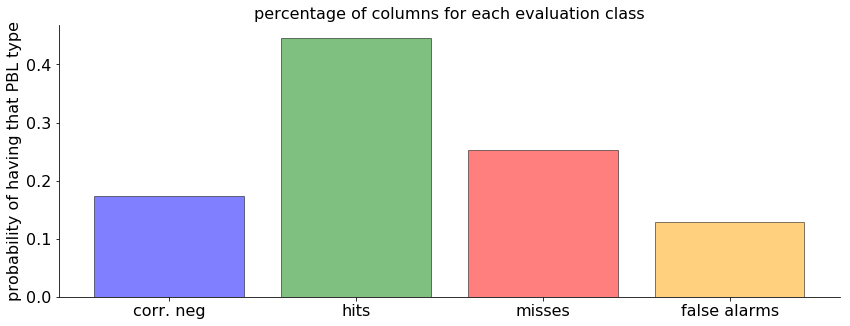

In [28]:
# --- plot histogram of occurrence of different classes for method 2 
ClassesTypesPlot = {'correct_negatives':0,'hits':0,'missed':0,'false_alarms':0}
ClassesTypesPlot['correct_negatives'] = flagClasses2.count(0)/totColumns2
ClassesTypesPlot['hits'] = flagClasses2.count(1)/totColumns2
ClassesTypesPlot['missed'] = flagClasses2.count(2)/totColumns2
ClassesTypesPlot['false_alarms'] = flagClasses2.count(3)/totColumns2
plt.figure('evaluation classes', figsize=[14,5])
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
objects = ('corr. neg', 'hits', 'misses', 'false alarms')
y_pos = np.arange(len(objects))
performance = ClassesTypesPlot.values()
my_colors = ['blue', 'green', 'red', 'orange']
my_edgecolor = ['black', 'black', 'black', 'black']
probs = [0.17324492158720134, 0.4456373013367014, 0.25186822439743184, 0.1292495526786654]
POD = probs[1]/(probs[1]+probs[2])
FAR = probs[3]/(probs[1]+probs[3])
BIAS = (probs[1]+probs[3])/(probs[1]+probs[2])
ACC = (probs[1]+probs[0])/(probs[1]+probs[2]+probs[0]+probs[3])
POFD = probs[3]/(probs[0]+probs[3])
print(POD)
print(FAR)
print(BIAS)
print(ACC)
print(POFD)
print()
plt.bar(y_pos, performance, align='center', alpha=0.5, color=my_colors, width = 0.8, edgecolor=my_edgecolor)
plt.xticks(y_pos, objects)
plt.ylabel('probability of having that PBL type', fontsize=16)
plt.title('percentage of columns for each evaluation class', fontsize=16)
plt.savefig(pathFig+'PercentageCloudClasses_histogram.png')

In [75]:
len(flagClasses2)


9501

In [29]:
# ---- comparing cloud base and cloud thickness for each separate evaluation class (version 1)
#  - noCloudModel/noCloudObs = 0 (correct negative)
#  - cloudModel/cloudobs = 1 (hit)
#  - noCloudModel/cloudObs = 2 (missed)
#  - cloudModel/noCloudObs = 3 (false alarm)
# ---- variables to analize

CB_obs_HT = []
CB_mod_HT = []
CB_obs_MS = []
CB_mod_FA = []

CT_obs_HT = []
CT_mod_HT = []
CT_obs_MS = []
CT_mod_FA = []

dateTime_CN = []
dateTime_HT = []
dateTime_MS = []
dateTime_FA = []

thickness_CN_obs = []
thickness_HT_obs = []
thickness_MS_obs = []
thickness_FA_obs = []
thickness_CN_mod = []
thickness_HT_mod = []
thickness_MS_mod = []
thickness_FA_mod = []


varianceW_CN_obs = []
varianceW_HT_obs = []
varianceW_MS_obs = []
varianceW_FA_obs = []
varianceW_CN_mod = []
varianceW_HT_mod = []
varianceW_MS_mod = []
varianceW_FA_mod = []

LTS_CN_mod = []
LTS_CN_obs = []
LCL_CN_mod = []
LCL_CN_obs = []

LTS_HT_mod = []
LTS_HT_obs = []
LCL_HT_mod = []
LCL_HT_obs = []

LTS_MS_mod = []
LTS_MS_obs = []
LCL_MS_mod = []
LCL_MS_obs = []

LTS_FA_mod = []
LTS_FA_obs = []
LCL_FA_mod = []
LCL_FA_obs = []

LWP_CN_mod = []
LWP_CN_obs = []
IWV_CN_mod = []
IWV_CN_obs = []

LWP_HT_mod = []
LWP_HT_obs = []
IWV_HT_mod = []
IWV_HT_obs = []

LWP_MS_mod = []
LWP_MS_obs = []
IWV_MS_mod = []
IWV_MS_obs = []

LWP_FA_mod = []
LWP_FA_obs = []
IWV_FA_mod = []
IWV_FA_obs = []


# loop on time array. Based on flagClasses we collect different datasets
for indTime in range(len(time_ICON)):
            
    # processing only bins belonging to the specific class and storing values in the corresponding lists
    if flagClasses[indTime-halfInt-1] == 0:             # noCloudModel/noCloudObs = 0 (correct negative)

         # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
        if ind_CB_obs[indTime] != -1:
            varianceW_CN_obs.append(varianceW_obs[indTime,0:ind_CB_obs[indTime]])
        else:
            varianceW_CN_obs.append(varianceW_obs[indTime,0:f_closest(height_PBL_class,2000.)])
        if ind_CB_mod[indTime-halfInt] != -1:        
            varianceW_CN_mod.append(varw_ICON[indTime,0:ind_CB_mod[indTime]])
        else:
            varianceW_CN_mod.append(varw_ICON[indTime,0:f_closest(height_ICON,2000)])

        # storing values of LCL, LTS and time
        LCL_CN_mod.append(LCL_ICON[indTime])
        LCL_CN_obs.append(LCLarray[indTime]) 
        LTS_CN_mod.append(LTS_ICON[indTime])
        LTS_CN_obs.append(LTS[indTime])
        dateTime_CN.append(datetime_ICON[indTime])
        LWP_CN_obs.append(MWR_resampled.values[indTime])
        LWP_CN_mod.append(LWP_ICON[indTime])
        IWV_CN_obs.append(IWV_resampled.values[indTime])
        IWV_CN_mod.append(IWV_ICON[indTime])


    if flagClasses[indTime-halfInt-1] == 1:             #  - cloudModel/cloudobs = 1 (hit)

        # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
        if ind_CB_obs[indTime] != -1:
            varianceW_HT_obs.append(varianceW_obs[indTime,0:ind_CB_obs[indTime]])
        if ind_CB_mod[indTime] != -1:        
            varianceW_HT_mod.append(varw_ICON[indTime,0:ind_CB_mod[indTime]])

        # storing values of LCL, LTS and time
        LCL_HT_mod.append(LCL_ICON[indTime])
        LCL_HT_obs.append(LCLarray[indTime]) 
        LTS_HT_mod.append(LTS_ICON[indTime])
        LTS_HT_obs.append(LTS[indTime])
            
        # assigning cloud properties (for model, averaging over the time window considered)
        CB_obs_HT.append(CBarray_obs[indTime,0])
        CB_mod_HT.append(CBarray_mod[indTime,0])
        CT_obs_HT.append(CTarray_obs[indTime,0])
        CT_mod_HT.append(CTarray_mod[indTime,0])
        thickness_HT_obs.append(cloudThickness_obs[indTime,0])
        thickness_HT_mod.append(cloudThickness_mod[indTime,0])
        dateTime_HT.append(datetime_ICON[indTime])
        LWP_HT_obs.append(MWR_resampled.values[indTime])
        LWP_HT_mod.append(LWP_ICON[indTime])
        IWV_HT_obs.append(IWV_resampled.values[indTime])
        IWV_HT_mod.append(IWV_ICON[indTime])        

    if flagClasses[indTime-halfInt-1] == 2:             #  - noCloudModel/cloudObs = 2 (missed)

        # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
        varianceW_MS_obs.append(varianceW_obs[indTime,0:ind_CB_obs[indTime]])
        varianceW_MS_mod.append(varw_ICON[indTime,0:f_closest(height_ICON,2000.)])

        # storing values of LCL, LTS and time
        # LCL_MS_mod.append(LCL_ICON[indTime])
        LCL_MS_obs.append(LCLarray[indTime]) 
        LTS_MS_mod.append(LTS_ICON[indTime])
        LTS_MS_obs.append(LTS[indTime])
        CB_obs_MS.append(CBarray_obs[indTime,0])
        CT_obs_MS.append(CTarray_obs[indTime,0])
        thickness_MS_obs.append(cloudThickness_obs[indTime,0])
        dateTime_MS.append(datetime_ICON[indTime])
        LWP_MS_obs.append(MWR_resampled.values[indTime])
        LWP_MS_mod.append(LWP_ICON[indTime])
        IWV_MS_obs.append(IWV_resampled.values[indTime])
        IWV_MS_mod.append(IWV_ICON[indTime])                                

    if flagClasses[indTime-halfInt-1] == 3:          #  - cloudModel/noCloudObs = 3 (false alarm)

        # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
        varianceW_MS_obs.append(varianceW_obs[indTime,0:f_closest(height_PBL_class,2000.)])
        varianceW_FA_mod.append(varw_ICON[indTime,0:ind_CB_mod[indTime]])

        # storing values of LCL, LTS and time
        LCL_FA_mod.append(LCL_ICON[indTime])
        LCL_FA_obs.append(LCLarray[indTime]) 
        LTS_FA_mod.append(LTS_ICON[indTime])
        LTS_FA_obs.append(LTS[indTime])                                
        CT_mod_FA.append(CTarray_mod[indTime,0])
        CB_mod_FA.append(CBarray_mod[indTime,0])
        thickness_FA_mod.append(cloudThickness_mod[indTime,0])
        dateTime_FA.append(datetime_ICON[indTime])

        LWP_FA_obs.append(MWR_resampled.values[indTime])
        LWP_FA_mod.append(LWP_ICON[indTime])
        IWV_FA_obs.append(IWV_resampled.values[indTime])
        IWV_FA_mod.append(IWV_ICON[indTime])


NameError: name 'flagClasses' is not defined

In [30]:
# ---- comparing cloud base and cloud thickness for each separate evaluation class (version 2)
#  - noCloudModel/noCloudObs = 0 (correct negative)
#  - cloudModel/cloudobs = 1 (hit)
#  - noCloudModel/cloudObs = 2 (missed)
#  - cloudModel/noCloudObs = 3 (false alarm)
# ---- variables to analize

CB_obs_HT = []
CB_mod_HT = []
CB_obs_MS = []
CB_mod_FA = []

CT_obs_HT = []
CT_mod_HT = []
CT_obs_MS = []
CT_mod_FA = []

dateTime_CN = []
dateTime_HT = []
dateTime_MS = []
dateTime_FA = []

thickness_CN_obs = []
thickness_HT_obs = []
thickness_MS_obs = []
thickness_FA_obs = []
thickness_CN_mod = []
thickness_HT_mod = []
thickness_MS_mod = []
thickness_FA_mod = []


varianceW_CN_obs = []
varianceW_HT_obs = []
varianceW_MS_obs = []
varianceW_FA_obs = []
varianceW_CN_mod = []
varianceW_HT_mod = []
varianceW_MS_mod = []
varianceW_FA_mod = []

z_ccl_HT = []
z_ccl_MS = []
z_ccl_FA = []
z_ccl_CN = []


LTS_CN_mod = []
LTS_CN_obs = []
LCL_CN_mod = []
LCL_CN_obs = []

LTS_HT_mod = []
LTS_HT_obs = []
LCL_HT_mod = []
LCL_HT_obs = []

LTS_MS_mod = []
LTS_MS_obs = []
LCL_MS_mod = []
LCL_MS_obs = []

LTS_FA_mod = []
LTS_FA_obs = []
LCL_FA_mod = []
LCL_FA_obs = []

LWP_CN_mod = []
LWP_CN_obs = []
IWV_CN_mod = []
IWV_CN_obs = []

LWP_HT_mod = []
LWP_HT_obs = []
IWV_HT_mod = []
IWV_HT_obs = []

LWP_MS_mod = []
LWP_MS_obs = []
IWV_MS_mod = []
IWV_MS_obs = []

LWP_FA_mod = []
LWP_FA_obs = []
IWV_FA_mod = []
IWV_FA_obs = []


# loop on time array. Based on flagClasses we collect different datasets
for indTime in range(len(time_ICON)):
    
    if ((indTime > halfInt) and (indTime < len(time_ICON)-halfInt)):
        
        # processing only bins belonging to the specific class and storing values in the corresponding lists
        if flagClasses2[indTime-halfInt-1] == 0:             # noCloudModel/noCloudObs = 0 (correct negative)

            # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
            if ind_CB_obs[indTime] != -1:
                varianceW_CN_obs.append(varianceW_obs[indTime,0:ind_CB_obs[indTime]])
            else:
                varianceW_CN_obs.append(varianceW_obs[indTime,0:f_closest(height_PBL_class,2000.)])
            if ind_CB_mod[indTime-halfInt] != -1:        
                varianceW_CN_mod.append(varw_ICON[indTime,0:ind_CB_mod[indTime]])
            else:
                varianceW_CN_mod.append(varw_ICON[indTime,0:f_closest(height_ICON,2000)])

            # storing values of LCL, LTS and time
            LCL_CN_mod.append(LCL_ICON[indTime])
            LCL_CN_obs.append(LCLarray[indTime]) 
            LTS_CN_mod.append(LTS_ICON[indTime])
            LTS_CN_obs.append(LTS[indTime])
            dateTime_CN.append(datetime_ICON[indTime])
            z_ccl_CN.append(z_ccl[indTime])
            
            LWP_CN_obs.append(MWR_resampled.values[indTime])
            LWP_CN_mod.append(LWP_ICON[indTime])
            IWV_CN_obs.append(IWV_resampled.values[indTime])
            IWV_CN_mod.append(IWV_ICON[indTime])


        if flagClasses2[indTime-halfInt-1] == 1:             #  - cloudModel/cloudobs = 1 (hit)

            # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
            if ind_CB_obs[indTime] != -1:
                varianceW_HT_obs.append(varianceW_obs[indTime,0:ind_CB_obs[indTime]])
            if ind_CB_mod[indTime] != -1:        
                varianceW_HT_mod.append(varw_ICON[indTime,0:ind_CB_mod[indTime]])

            # storing values of LCL, LTS and time
            LCL_HT_mod.append(LCL_ICON[indTime])
            LCL_HT_obs.append(LCLarray[indTime]) 
            LTS_HT_mod.append(LTS_ICON[indTime])
            LTS_HT_obs.append(LTS[indTime])
            z_ccl_HT.append(z_ccl[indTime])

            # assigning cloud properties (for model, averaging over the time window considered)
            CB_obs_HT.append(CBarray_obs[indTime,0])
            CB_mod_HT.append(CBarray_mod[indTime,0])
            CT_obs_HT.append(CTarray_obs[indTime,0])
            CT_mod_HT.append(CTarray_mod[indTime,0])
            thickness_HT_obs.append(cloudThickness_obs[indTime,0])
            thickness_HT_mod.append(cloudThickness_mod[indTime,0])
            dateTime_HT.append(datetime_ICON[indTime])
            #print(np.median(LWP_ICON[indTime-halfInt:indTime+halfInt]))
            LWP_HT_obs.append(MWR_resampled.values[indTime])
            LWP_HT_mod.append(np.median(LWP_ICON[indTime-halfInt:indTime+halfInt]))
            IWV_HT_obs.append(IWV_resampled.values[indTime])
            IWV_HT_mod.append(np.median(IWV_ICON[indTime-halfInt:indTime+halfInt]))        

        if flagClasses2[indTime-halfInt-1] == 2:             #  - noCloudModel/cloudObs = 2 (missed)

            # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
            varianceW_MS_obs.append(varianceW_obs[indTime,0:ind_CB_obs[indTime]])
            varianceW_MS_mod.append(varw_ICON[indTime,0:f_closest(height_ICON,2000.)])

            # storing values of LCL, LTS and time
           # LCL_MS_mod.append(LCL_ICON[indTime])
            LCL_MS_obs.append(LCLarray[indTime]) 
            LTS_MS_mod.append(LTS_ICON[indTime])
            LTS_MS_obs.append(LTS[indTime])
            z_ccl_MS.append(z_ccl[indTime])

            CB_obs_MS.append(CBarray_obs[indTime,0])
            CT_obs_MS.append(CTarray_obs[indTime,0])
            thickness_MS_obs.append(cloudThickness_obs[indTime,0])
            dateTime_MS.append(datetime_ICON[indTime])
            LWP_MS_obs.append(MWR_resampled.values[indTime])
            LWP_MS_mod.append(LWP_ICON[indTime])
            IWV_MS_obs.append(IWV_resampled.values[indTime])
            IWV_MS_mod.append(IWV_ICON[indTime])                                

        if flagClasses2[indTime-halfInt-1] == 3:          #  - cloudModel/noCloudObs = 3 (false alarm)

            # storing column of variance of vertical velocity from ground to 2000 mt height or to cloud base if present
            varianceW_FA_obs.append(varianceW_obs[indTime,0:f_closest(height_PBL_class,2000.)])
            varianceW_FA_mod.append(varw_ICON[indTime,0:ind_CB_mod[indTime]])

            # storing values of LCL, LTS and time
            LCL_FA_mod.append(LCL_ICON[indTime])
            LCL_FA_obs.append(LCLarray[indTime]) 
            LTS_FA_mod.append(LTS_ICON[indTime])
            LTS_FA_obs.append(LTS[indTime]) 
            z_ccl_FA.append(z_ccl[indTime])

            CT_mod_FA.append(CTarray_mod[indTime,0])
            CB_mod_FA.append(CBarray_mod[indTime,0])
            thickness_FA_mod.append(cloudThickness_mod[indTime,0])
            dateTime_FA.append(datetime_ICON[indTime])

            LWP_FA_obs.append(MWR_resampled.values[indTime])
            LWP_FA_mod.append(np.median(LWP_ICON[indTime-halfInt:indTime+halfInt]))
            IWV_FA_obs.append(IWV_resampled.values[indTime])
            IWV_FA_mod.append(np.median(IWV_ICON[indTime-halfInt:indTime+halfInt]))


NameError: name 'varianceW_obs' is not defined

In [124]:
print(np.shape(varianceW_HT_obs))
print(np.shape(varianceW_MS_obs))
print(np.shape(varianceW_FA_obs))
print(np.shape(varianceW_CN_obs))
print(np.shape(varianceW_HT_mod))
print(np.shape(varianceW_MS_mod))
print(np.shape(varianceW_FA_mod))
print(np.shape(varianceW_CN_mod))

(4214,)
(2393,)
(1227, 66)
(1646,)
(2980,)
(2393, 118)
(1227,)
(1646, 118)


In [ ]:
# ---- deriving pdfs of variance and shear of Hwind for each category
xmin =0.
xmax=0.8
nbins=50.
bins = np.linspace(xmin, xmax, nbins)
print(np.shape(bins))
fig, ax = plt.subplots(figsize=(14,5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.hist(cloudThickness_obs[:,0], bins, normed=1, alpha=0.5, label='obs', color='black', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.hist(cloudThickness_mod[:,0], bins, normed=1, alpha=0.5, label='ICON', color='red', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('Relative occurrences', fontsize=16)
plt.xlabel('Geometrical cloud thickness [m]', fontsize=16)
plt.title('Distribution of geometrical cloud thicknesses: comparison ICON/obs', fontsize=16)
plt.savefig(pathFig+'PDF_geoThickness_obs_ICON.png')

(4234,)
(4234,)
(4234, 1)
(4234,)


(734990.3333333334, 734990.75)

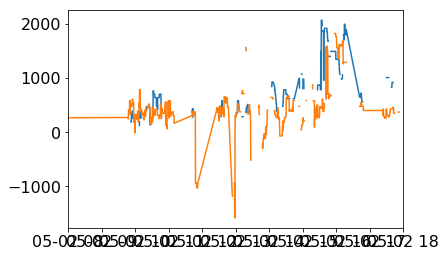

In [108]:
# calculating differences in cloud base height and cloud top heights
diff_CB_HT = np.asarray(CB_obs_HT)-np.asarray(CB_mod_HT)
diff_CT_HT = np.asarray(CT_obs_HT)-np.asarray(CT_mod_HT)
diff_CCL_HT_mod = np.asarray(CT_mod_HT)-np.asarray(z_ccl_HT)
diff_CCL_HT_obs = np.asarray(CT_obs_HT)-np.asarray(z_ccl_HT)

#diff_LWP_HT = np.asarray(LWP_HT_obs[:,0])-np.asarray(LWP_HT_mod)
#diff_IWV_HT = np.asarray(IWV_HT_obs[:,0])-np.asarray(IWV_HT_mod)
print(np.shape(CB_obs_HT))
print(np.shape(IWV_HT_mod))
print(np.shape(LWP_HT_obs))
print(np.shape(LWP_HT_mod))
diffLWP =[]
diffIWV =[]
for indtime in range(len(dateTime_HT)):
    
    diffLWP.append(LWP_HT_obs[indtime]*1000.-LWP_HT_mod[indtime]*1000.)
    diffIWV.append(IWV_HT_obs[indtime]*1000.-IWV_HT_mod[indtime]*1000.)
diff_LWP=np.asarray(diffLWP)
diff_IWV=np.asarray(diffIWV)





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning:

pd.rolling_median is deprecated for ndarrays and will be removed in a future version

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning:

pd.rolling_median is deprecated for ndarrays and will be removed in a future version



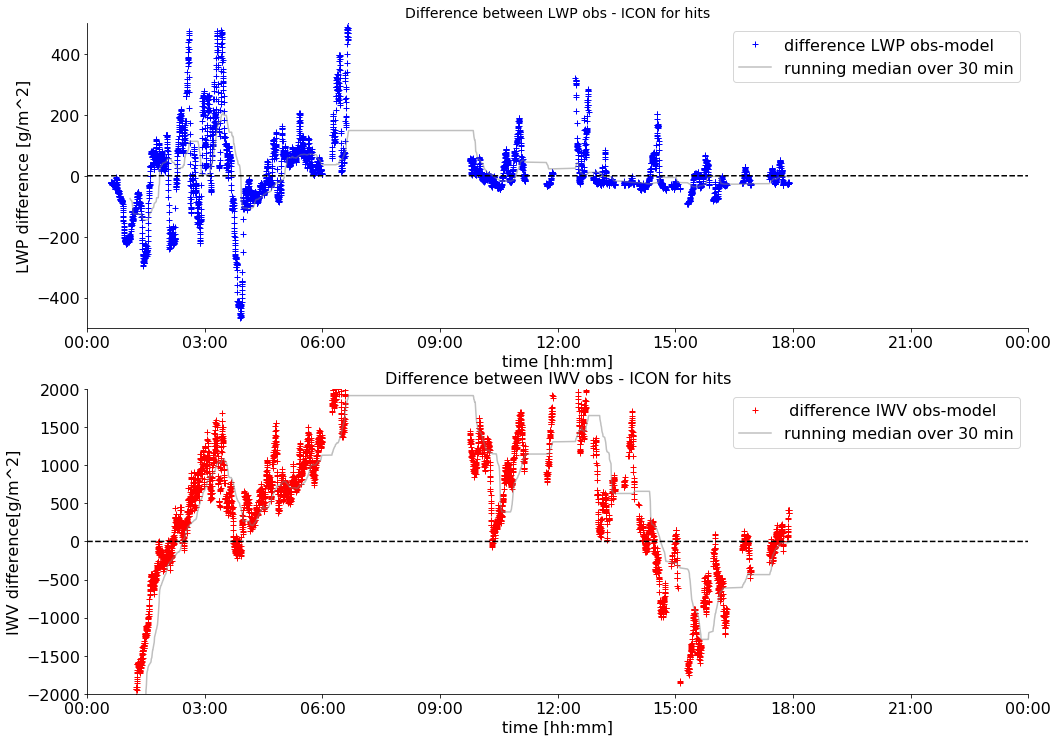

In [98]:
# ---- plotting differences in IWV and LWP for hits

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(14,10))
plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
ax = plt.subplot(2,1,1)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
plt.title('Difference between LWP obs - ICON for hits', fontsize=14)
plt.plot(datetime_ICON, MWR_resampled.values[:]-MWR_resampled.values[:], color='black', alpha=0.00)
plt.plot(dateTime_HT, diffLWP, '+',  color='b', label='difference LWP obs-model')
plt.plot(dateTime_HT, pd.rolling_median(np.asarray(diffLWP), 200), color='grey', alpha=0.5, label='running median over 30 min')
plt.plot(datetime_ICON, np.zeros(len(datetime_ICON)),  color='black', linestyle='--')

plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.ylim(-500., 500.)
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('time [hh:mm]', fontsize=16)
plt.ylabel('LWP difference [g/m^2]', fontsize=16)



ax = plt.subplot(2, 1, 2)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
plt.title('Difference between IWV obs - ICON for hits', fontsize=16)
plt.plot(datetime_ICON, np.zeros(len(datetime_ICON)), color='black', alpha=0.00)
plt.plot(dateTime_HT, diffIWV, '+', color='r', label=' difference IWV obs-model')
plt.plot(dateTime_HT, pd.rolling_median(np.asarray(diffIWV), 200), color='grey', alpha=0.5, label='running median over 30 min')
plt.plot(datetime_ICON, np.zeros(len(datetime_ICON)),  color='black', linestyle='--')
plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('time [hh:mm]', fontsize=16)
plt.ylabel('IWV difference[g/m^2]', fontsize=16)
plt.ylim(-2000., 2000.)
plt.savefig(pathFig+'IWV_difference_obs_ICON.png')

plt.savefig(pathFig+'LWP_difference_obs_ICON.png')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



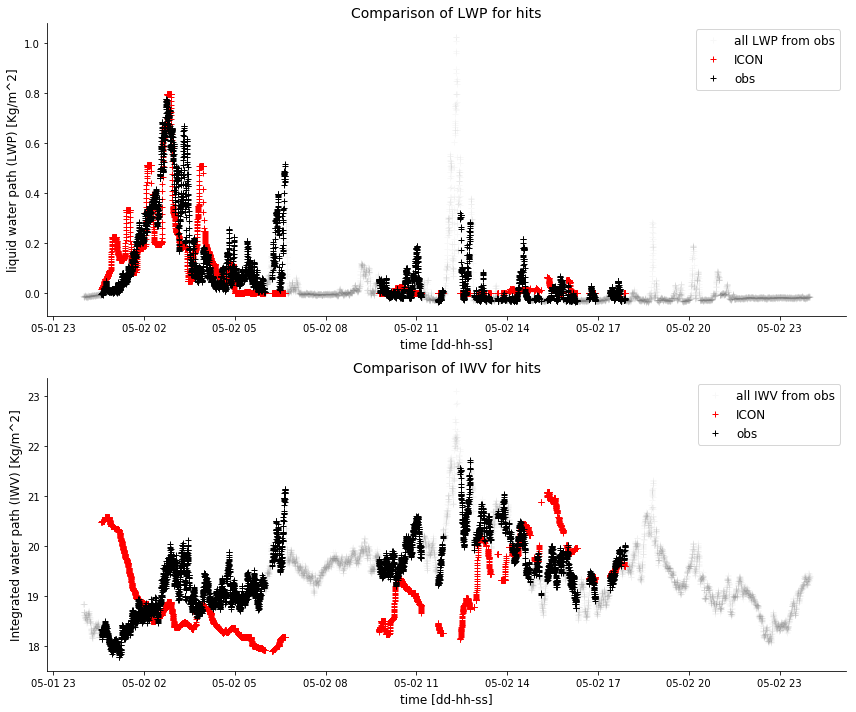

In [101]:
# ---- plotting comparison of IWV/LWP for the different evaluation classes
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(figsize=(12,10))
fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)

ax = plt.subplot(2, 1, 1) 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Comparison of LWP for hits', fontsize=14)
plt.plot(datetime_ICON, MWR_resampled.values[:],  '+', color='grey', alpha=0.05, label='all LWP from obs')
plt.plot(dateTime_HT, LWP_HT_mod, '+', color='r', label='ICON')
plt.plot(dateTime_HT, LWP_HT_obs, '+', color='black', label='obs')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('liquid water path (LWP) [Kg/m^2]', fontsize=12)

ax = plt.subplot(2, 1, 2)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Comparison of IWV for hits', fontsize=14)
plt.plot(datetime_ICON, IWV_resampled.values[:],  '+', color='grey', alpha=0.05, label='all IWV from obs')
plt.plot(dateTime_HT, IWV_HT_mod, '+', color='r', label='ICON')
plt.plot(dateTime_HT, IWV_HT_obs, '+', color='black', label='obs')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('Integrated water path (IWV) [Kg/m^2]', fontsize=12)
plt.savefig(pathFig+'LWP_IWV_timeseries_obs_ICON.png')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



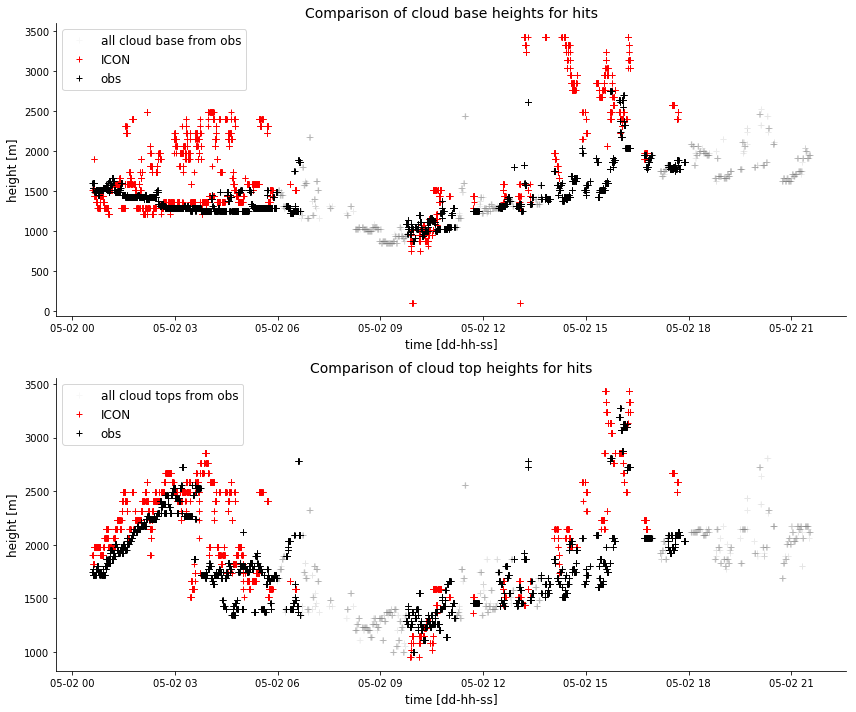

In [102]:
# ---- plotting comparison of cloud base heights for the different evaluation classes
fig, ax = plt.subplots(figsize=(12,10))
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
ax = plt.subplot(2, 1, 1) 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Comparison of cloud base heights for hits', fontsize=14)
plt.plot(datetime_ICON, CBarray_obs[:,0],  '+', color='grey', alpha=0.05, label='all cloud base from obs')
plt.plot(dateTime_HT, CB_mod_HT, '+', color='r', label='ICON')
plt.plot(dateTime_HT, CB_obs_HT, '+', color='black', label='obs')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('height [m]', fontsize=12)

ax = plt.subplot(2, 1, 2)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Comparison of cloud top heights for hits', fontsize=14)
plt.plot(datetime_ICON, CTarray_obs[:,0],  '+', color='grey', alpha=0.05, label='all cloud tops from obs')
plt.plot(dateTime_HT, CT_mod_HT, '+', color='r', label='ICON')
plt.plot(dateTime_HT, CT_obs_HT, '+', color='black', label='obs')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('height [m]', fontsize=12)
plt.savefig(pathFig+'CB_CT_timeseries_obs_ICON.png')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning:

pd.rolling_median is deprecated for ndarrays and will be removed in a future version

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning:

pd.rolling_median is deprecated for ndarrays and will be removed in a future version

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



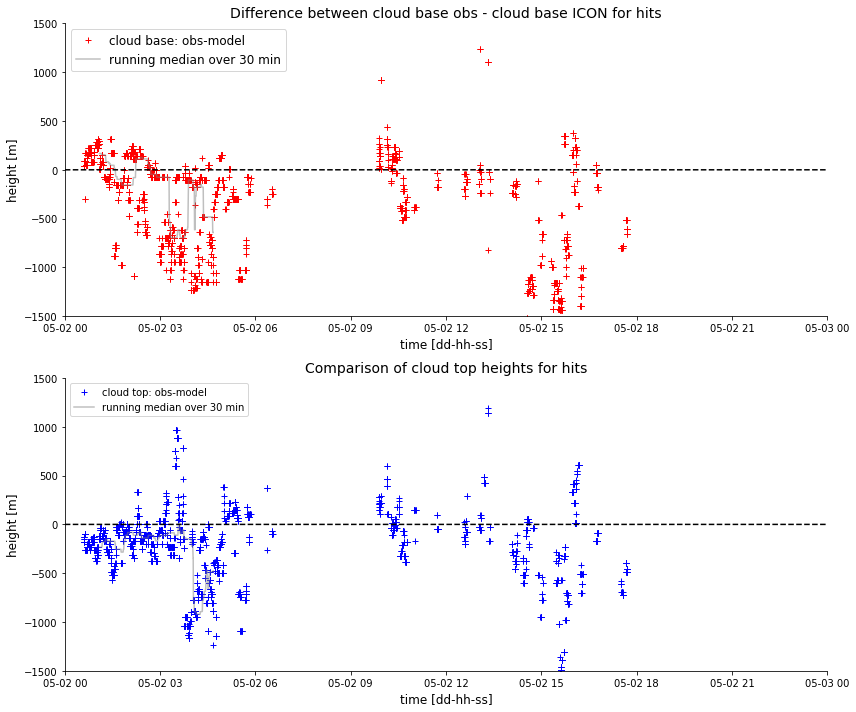

In [103]:
# ---- plotting differences in cloud base and cloud tops for hits
fig, ax = plt.subplots(figsize=(12,10))
plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
ax = plt.subplot(2, 1, 1) 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Difference between cloud base obs - cloud base ICON for hits', fontsize=14)
plt.plot(datetime_ICON, CBarray_obs[:,0]-CBarray_obs[:,0], color='black', alpha=0.00)
plt.plot(dateTime_HT, diff_CB_HT, '+', color='r', label='cloud base: obs-model')
plt.plot(dateTime_HT, pd.rolling_median(diff_CB_HT, 200), color='grey', alpha=0.5, label='running median over 30 min')
plt.plot(datetime_ICON, np.zeros(len(datetime_ICON)),  color='black', linestyle='--')
plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('height [m]', fontsize=12)
plt.ylim(-1500., 1500.)



ax = plt.subplot(2, 1, 2)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Comparison of cloud top heights for hits', fontsize=14)
plt.plot(datetime_ICON, CTarray_obs[:,0]-CTarray_obs[:,0], color='black', alpha=0.00)
plt.plot(dateTime_HT, diff_CT_HT, '+',  color='b', label='cloud top: obs-model')
plt.plot(dateTime_HT, pd.rolling_median(diff_CT_HT, 200), color='grey', alpha=0.5, label='running median over 30 min')
plt.plot(datetime_ICON, np.zeros(len(datetime_ICON)),  color='black', linestyle='--')

plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.ylim(-1500., 1500.)
plt.legend(loc='upper left')
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('height [m]', fontsize=12)
plt.savefig(pathFig+'CB_CT_differences_obs_ICON.png')

In [159]:

# converting lists to arrays
a = np.asarray(IWV_CN_obs)
b = a.ravel()
c = np.asarray(IWV_CN_mod)
d = c.ravel()
# determine best fit line
parCN = np.polyfit(b,d, 1, full=True)
slope=parCN[0][0]
intercept=parCN[0][1]
xl = [min(b), max(b)]
yl = [slope*xx + intercept  for xx in xl]


# converting lists to arrays
a = np.asarray(IWV_HT_obs)
b = a.ravel()
c = np.asarray(IWV_HT_mod)
d = c.ravel()
# determine best fit line
parHT = np.polyfit(b,d, 1, full=True)
slope=parHT[0][0]
intercept=parHT[0][1]
x2 = [min(b), max(b)]
y2 = [slope*xx + intercept  for xx in x2]



# converting lists to arrays
a = np.asarray(IWV_FA_obs)
b = a.ravel()
c = np.asarray(IWV_FA_mod)
d = c.ravel()
# determine best fit line
parFA = np.polyfit(b,d, 1, full=True)
slope=parFA[0][0]
intercept=parFA[0][1]
x3 = [min(b), max(b)]
y3 = [slope*xx + intercept  for xx in x3]


# converting lists to arrays
a = np.asarray(IWV_MS_obs)
b = a.ravel()
c = np.asarray(IWV_MS_mod)
d = c.ravel()
# determine best fit line
parMS = np.polyfit(b,d, 1, full=True)
slope=parMS[0][0]
intercept=parMS[0][1]
x4 = [min(b), max(b)]
y4 = [slope*xx + intercept  for xx in x4]

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



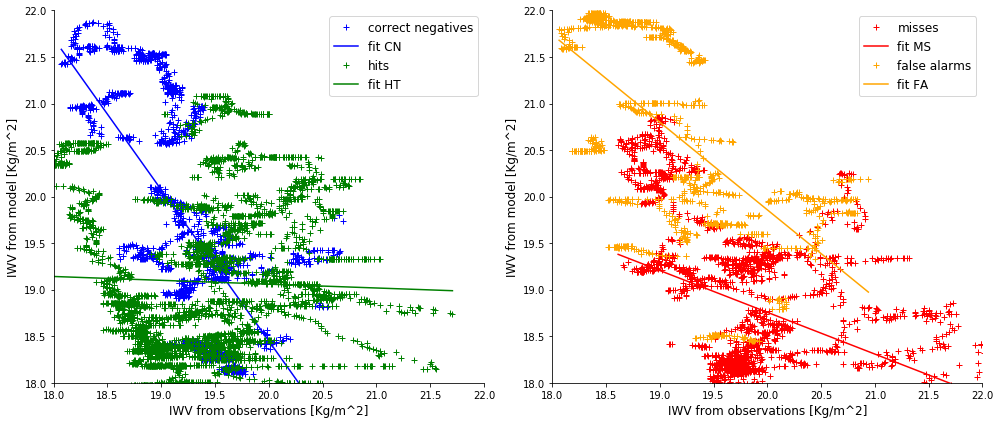

In [160]:
# ---- plotting histograms of LWP and IWV for misses and false alarms




# ---- plotting scatter plots of LTS for all categories
plt.figure( figsize=[14,6])
plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
ax = plt.subplot(121)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlim(18., 22.)
plt.ylim(18., 22.)
plt.plot(IWV_CN_obs, IWV_CN_mod, 'y+', label='correct negatives', color='blue')
plt.plot(xl, yl, color='blue', label='fit CN')
plt.plot(IWV_HT_obs, IWV_HT_mod, 'b+', label='hits', color='green')
plt.plot(x2, y2, color='green', label='fit HT')
#plt.plot(CB_obs_HT, CB_obs_HT)
plt.xlabel('IWV from observations [Kg/m^2]', fontsize=12)
plt.ylabel('IWV from model [Kg/m^2]', fontsize=12)
plt.legend(loc='upper right', fontsize=12)


ax = plt.subplot(122)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlim(18., 22.)
plt.ylim(18., 22.)
plt.plot(IWV_MS_obs, IWV_MS_mod, 'g+', label='misses', color='red')
plt.plot(x4, y4, color='red', label='fit MS')

plt.plot(IWV_FA_obs, IWV_FA_mod, 'r+', label='false alarms', color='orange')
plt.plot(x3, y3, color='orange', label='fit FA')
plt.xlabel('IWV from observations [Kg/m^2]', fontsize=12)
plt.ylabel('IWV from model [Kg/m^2]', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.savefig(pathFig+'scatterplot_IWV_allcategories.png')





KeyboardInterrupt: 

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



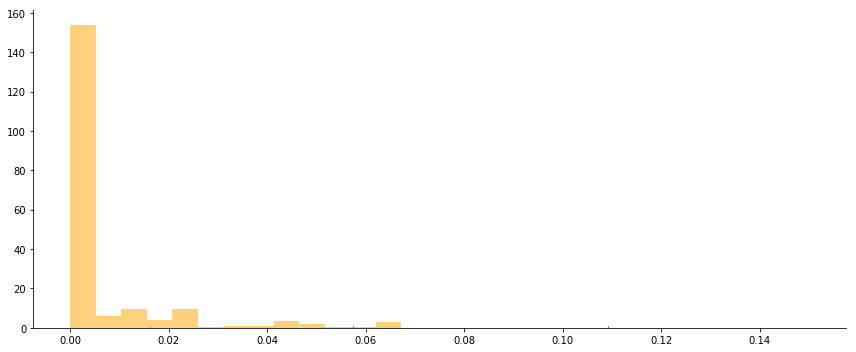

In [106]:
# plotting histograms for LWP missed and false alarms. (to be continued) 
fig, ax = plt.subplots(figsize=(12,5))
#fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
xmin = 0.
xmax = 0.15
nbins = 30
bins = np.linspace(xmin, xmax, nbins)
plt.hist(LWP_FA_mod, bins, normed=1, alpha=0.5, label='false alarms', color='orange', range=[xmin, xmax], align='mid', log=False, cumulative=False)
#xmin = 0.
#xmax = 1.5
#nbins = 30
#bins = np.linspace(xmin, xmax, nbins)
#plt.hist(LWP_MS_obs, bins, normed=0, alpha=0.5, label='misses', range=[xmin, xmax], align='mid', log=False, cumulative=False)

plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Relative occurrences', fontsize=12)
plt.xlabel('LWP [Kg/m^2]', fontsize=12)
plt.title('Distribution of LWP for misses and false alarms', fontsize=14)
plt.savefig(pathFig+'PDFs_LWP_falseAlarms.png')


In [ ]:
np.shape(LWP_MS_obs)
np.shape(LWP_FA_mod)
#print(np.max(LWP_MS_obs))

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



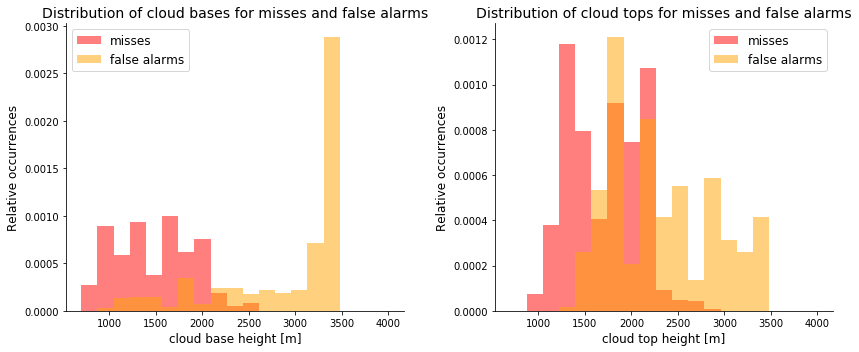

In [107]:
fig, ax = plt.subplots(figsize=(12,5))
fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax = plt.subplot(121)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
xmin = 700.
xmax = 4000.
nbins = 20
bins = np.linspace(xmin, xmax, nbins)
plt.hist(CB_obs_MS, bins, normed=1, alpha=0.5, label='misses', color='red', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.hist(CB_mod_FA, bins, normed=1, alpha=0.5, label='false alarms', color='orange', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Relative occurrences', fontsize=12)
plt.xlabel('cloud base height [m]', fontsize=12)
plt.title('Distribution of cloud bases for misses and false alarms', fontsize=14)


ax = plt.subplot(122)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
xmin = 700.
xmax = 4000.
nbins = 20
bins = np.linspace(xmin, xmax, nbins)
plt.hist(CT_obs_MS, bins, normed=1, alpha=0.5, label='misses', color='red', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.hist(CT_mod_FA, bins, normed=1, alpha=0.5, label='false alarms', color='orange', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Relative occurrences', fontsize=12)
plt.xlabel('cloud top height [m]', fontsize=12)
plt.title('Distribution of cloud tops for misses and false alarms', fontsize=14)
plt.savefig(pathFig+'PDFS_CB_CT_misses_falseAlarms.png')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



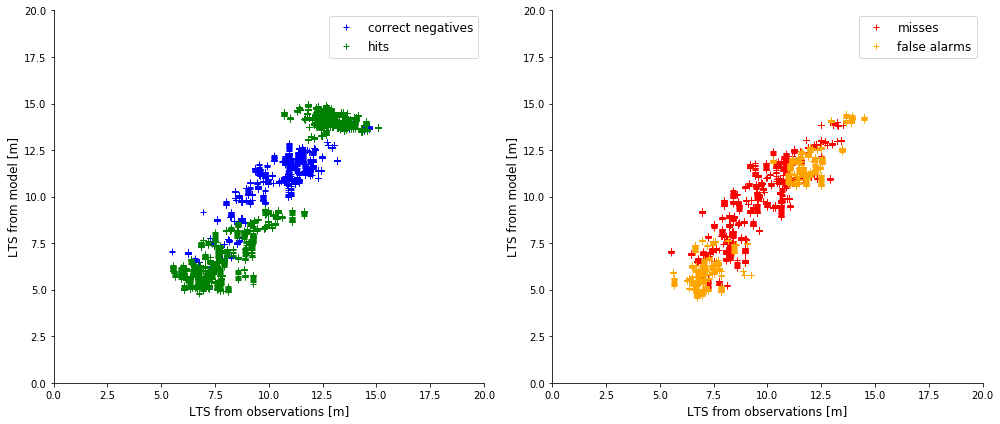

In [108]:
# ---- plotting scatter plots of LTS for all categories
plt.figure( figsize=[14,6])
plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
ax = plt.subplot(121)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlim(0., 20.)
plt.ylim(0., 20.)
plt.plot(LTS_CN_obs, LTS_CN_mod, 'y+', label='correct negatives', color='blue')
plt.plot(LTS_HT_obs, LTS_HT_mod, 'b+', label='hits', color='green')

#plt.plot(CB_obs_HT, CB_obs_HT)
plt.xlabel('LTS from observations [m]', fontsize=12)
plt.ylabel('LTS from model [m]', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
ax = plt.subplot(122)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlim(0., 20.)
plt.ylim(0., 20.)
plt.plot(LTS_MS_obs, LTS_MS_mod, 'g+', label='misses', color='red')
plt.plot(LTS_FA_obs, LTS_FA_mod, 'r+', label='false alarms', color='orange')
plt.xlabel('LTS from observations [m]', fontsize=12)
plt.ylabel('LTS from model [m]', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.savefig(pathFig+'scatterplot_LTS_allcategories.png')


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



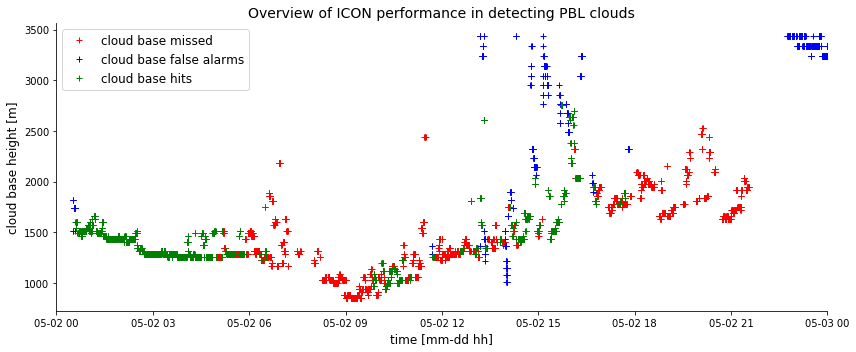

In [31]:
plt.figure( figsize=[12,5])
plt.gcf().subplots_adjust(bottom=0.15)
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.ylabel('cloud base height [m]', fontsize=12)
plt.xlabel('time [mm-dd hh]', fontsize=12)
plt.title('Overview of ICON performance in detecting PBL clouds', fontsize=14)
plt.plot(dateTime_MS, CB_obs_MS, 'r+', label='cloud base missed')
plt.plot(dateTime_FA, CB_mod_FA, 'b+', label='cloud base false alarms')
plt.plot(dateTime_HT, CB_obs_HT, 'g+', label='cloud base hits')
plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.legend(loc='upper left', fontsize=12)
plt.savefig(pathFig+'Overview_skills_ICON.png')


In [32]:
# calculating differences in geometrical thicknesses 
diff_geoThick_HT = np.asarray(thickness_HT_obs)-np.asarray(thickness_HT_mod)
np.shape(cloudThickness_obs)

(9601, 4)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



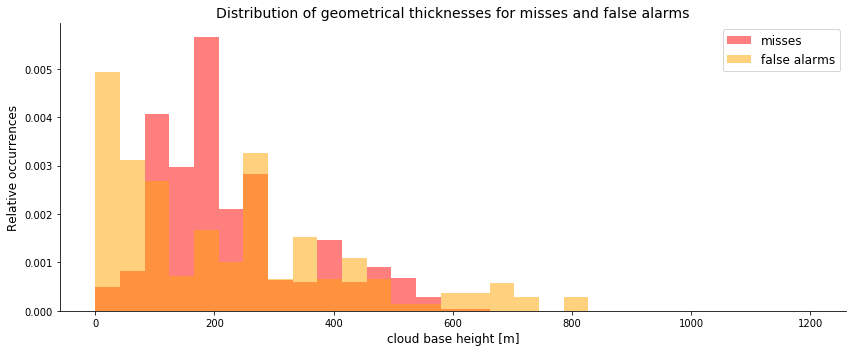

In [109]:
# --- distributions of geometrical thicknesses for misses and false alarms
fig, ax = plt.subplots(figsize=(12,5))
plt.gcf().subplots_adjust(bottom=0.15)
#ax = plt.subplot(121)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
xmin = 0.
xmax = 1200.
nbins = 30
bins = np.linspace(xmin, xmax, nbins)
plt.hist(thickness_MS_obs, bins, normed=1, alpha=0.5, label='misses', color='red', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.hist(thickness_FA_mod, bins, normed=1, alpha=0.5, label='false alarms', color='orange', range=[xmin, xmax], align='mid', log=False, cumulative=False)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Relative occurrences', fontsize=12)
plt.xlabel('cloud base height [m]', fontsize=12)
plt.title('Distribution of geometrical thicknesses for misses and false alarms', fontsize=14)
plt.savefig(pathFig+'PDF_geoThickness_misses_falseAlarms.png')



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning:

pd.rolling_median is deprecated for ndarrays and will be removed in a future version

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



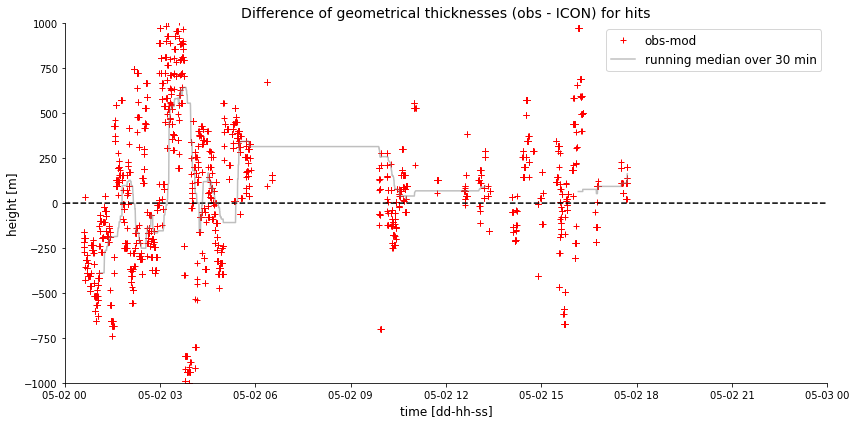

In [34]:
# ---- plot time series of differences of geometrical thicknesses for hits
fig, ax = plt.subplots(figsize=(12,6))
plt.gcf().subplots_adjust(bottom=0.15)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Difference of geometrical thicknesses (obs - ICON) for hits', fontsize=14)
plt.plot(datetime_ICON, cloudThickness_obs[:,0]-cloudThickness_mod[:,0], color='black', alpha=0.00)
plt.plot(dateTime_HT, diff_geoThick_HT, '+', color='r', label='obs-mod')
plt.plot(datetime_ICON, np.zeros(len(datetime_ICON)),  color='black', linestyle='--')
plt.plot(dateTime_HT, pd.rolling_median(diff_geoThick_HT, 200), color='grey', alpha=0.5, label='running median over 30 min')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('height [m]', fontsize=12)
plt.ylim(-1000., 1000.)
plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.legend(loc='upper right', fontsize=12)
plt.savefig(pathFig+'difference_geothickness_Hits.png')


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



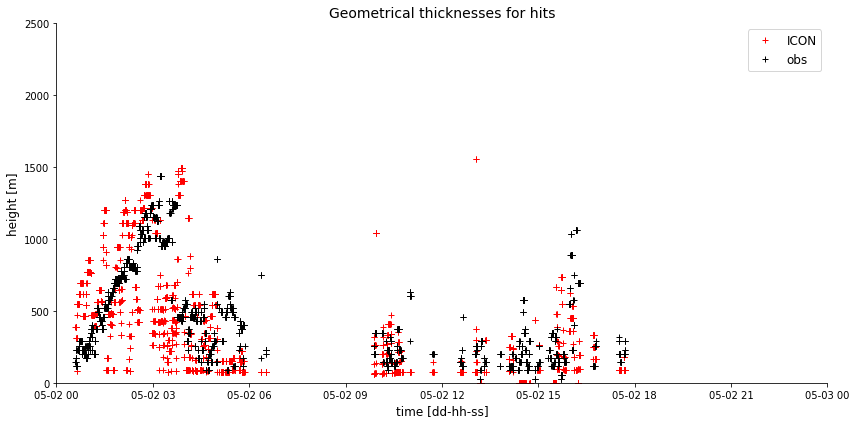

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
plt.gcf().subplots_adjust(bottom=0.15)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.title('Geometrical thicknesses for hits', fontsize=14)
plt.plot(datetime_ICON, cloudThickness_obs[:,0]-cloudThickness_mod[:,0], color='black', alpha=0.00)
plt.plot(dateTime_HT, thickness_HT_mod, '+', color='r', label='ICON')
plt.plot(dateTime_HT, thickness_HT_obs, '+', color='black', label='obs')
#plt.plot(dateTime_HT, pd.rolling_median(diff_geoThick_HT, 200), color='grey', alpha=0.5, label='running median over 30 min')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('time [dd-hh-ss]', fontsize=12)
plt.ylabel('height [m]', fontsize=12)
plt.ylim(0., 2500.)
plt.xlim(datetime_ICON[0], datetime_ICON[-1])
plt.legend(loc='upper right', fontsize=12)
plt.savefig(pathFig+'timeserie_geothickness_Hits.png')

In [24]:
# ---- building dictionaries of data with all resampled data 
# we store a dictionary containing all model and observational data. The goal is to then compare physical cloud and
# boundary layer properties for each class
dict_data = {'LWP_obs':MWR_resampled.values, 'time':datetime_ICON, 'height_mod':height_ICON, \
           'height_obs_CN':height_CLOUDNET, 'PBL_obs':PBL_resampled, 'beta_obs':beta_resampled, \
           'EDR_obs': eps_resampled, 'shear_obs':shear_resampled, 'skewness_obs':skew_resampled, \
           'w_obs':w_resampled, 'Hwind_obs':Hwind_resampled, \
           'classification_obs':CLOUDNET_resampled.values, 'skewness_mod':skewness_ICON, \
           'theta_mod':theta_ICON, 'thetal_mod':thetal_ICON, 'variancew_mod':varw_ICON, \
           'Hwind_mod':Hwind_ICON, 'shear_mod':shear_ICON, 'alphaq_mod':alphaq_ICON, 'alphatheta_mod':alphatheta_ICON, \
           'cloudbase_mod':cloudBase_ICON, 'LTS_mod':LTS_ICON, 'LCL_mod':LCL_ICON, 'w_mod':w_ICON, \
            'RH_mod':RH_ICON, 'r_mod':mixingRatio_ICON, 'q_mod':specHum_ICON, 'Hsurf_mod':Hsurf, \
            'IWV_mod': IWV_ICON, 'LWP_mod':LWP_ICON, 'P_mod':P_ICON, 'PBL_height_mod':PBL_class_ICON, \
            'T_mod':T_ICON}
            # 'Ze_obs':Ze_resampled, \'Vd_obs':Vd_resampled, 'Sw_obs':Sw_resampled,

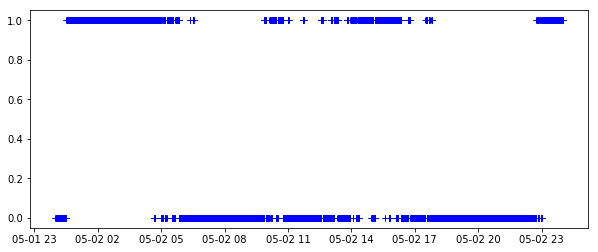

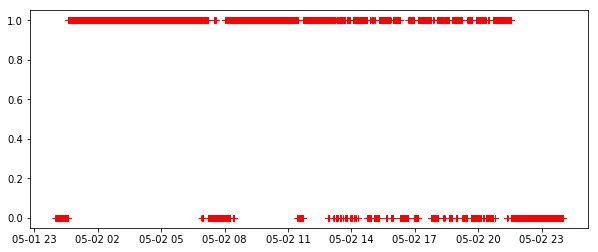

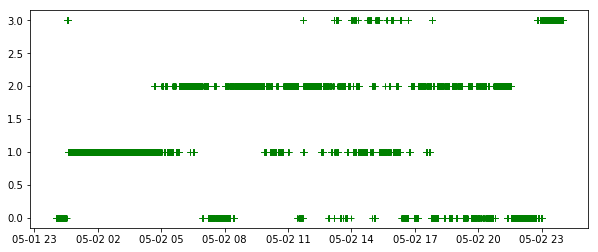

In [15]:
# ----- plotting cloud flag for ICON and CLOUDNET observations
#---------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(datetime_ICON, flagCloud_ICON, 'b+')

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(datetime_ICON, flagCloud_CLOUDNET, 'r+')

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(datetime_ICON, flagClasses, 'g+')


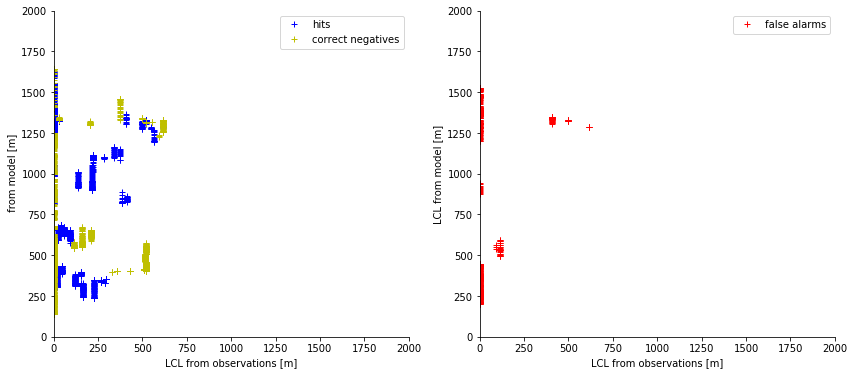

In [66]:

plt.figure( figsize=[14,6])
ax = plt.subplot(121)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlim(0., 2000.)
plt.ylim(0., 2000.)
plt.plot(LCL_HT_obs, LCL_HT_mod, 'b+', label='hits')
plt.plot(LCL_CN_obs, LCL_CN_mod, 'y+', label='correct negatives')
#plt.plot(CB_obs_HT, CB_obs_HT)
plt.xlabel('LCL from observations [m]')
plt.ylabel(' from model [m]')
plt.legend()
ax = plt.subplot(122)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlim(0., 2000.)
plt.ylim(0., 2000.)
#plt.plot(LCL_MS_obs, LCL_MS_mod, 'g+', label='misses')
plt.plot(LCL_FA_obs, LCL_FA_mod, 'r+', label='false alarms')
plt.xlabel('LCL from observations [m]')
plt.ylabel('LCL from model [m]')
plt.legend()